# Modèle avancé sur mesure

## Librairies

In [24]:
!pip install tensorflow

In [25]:
!pip install transformers

In [2]:
!pip install keras-tuner --upgrade

In [4]:
!pip install -U gensim

  Using cached Cython-0.29.28-py2.py3-none-any.whl (983 kB)


In [6]:
!pip install tweet-preprocessor

  Using cached tweet_preprocessor-0.6.0-py3-none-any.whl (27 kB)


In [156]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, Bidirectional, SimpleRNN, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch # optimisation hyperparamètres
from tensorflow.keras.optimizers import Adam
from gensim.models import FastText
import warnings
import random as rndm
import time
import io
from cycler import cycler
from IPython.core.display import HTML
import preprocessor as p # tweet-preprocessor https://github.com/s/preprocessor
from keras.models import Sequential, Model
from os.path import exists
import pickle
import json
# import spacy
from sklearn.metrics import accuracy_score

## Settings

In [80]:
warnings.filterwarnings('ignore')
plt.style.use('dark_background')
# tln = spacy.load("en_core_web_sm")
# Choisir une seed permet aux modélisations d'être reroductibles
seed = 1
rndm.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
sav_path = "./sav/"

## Importation des données

In [81]:
X = pickle.load(open(sav_path+"X.sav", "rb"))
X_lem = pickle.load(open(sav_path+"X_lem.sav", "rb"))
X_light = pickle.load(open(sav_path+"X_light.sav", "rb"))
y = pickle.load(open(sav_path+"y.sav", "rb"))

## Fonctions usuelles

In [82]:
def save_to_file(sav_path, filename, var):
    path_to_file = sav_path + filename
    pickle.dump(var, open(path_to_file, "wb"))
    return

def plot_metrics(model_history, model_name):
    plt.figure()
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.legend(['Train', 'Validation'])
    plt.title("{} : Accuracy en fonction du nombre d'epochs".format(model_name))
    plt.show()
    
    plt.figure()
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.legend(['Train', 'Validation'])
    plt.title("{} : Loss en fonction du nombre d'epochs".format(model_name))
    plt.show()

## Regression logistique

La régression logistique servira de baseline pour nos modèles de réseau neuronaux

In [83]:
model_tfidf = TfidfVectorizer()
X_tfidf = model_tfidf.fit_transform(X["train_smpl"])

In [84]:
model_LR = LogisticRegression(random_state=seed)
model_LR_tfidf = Pipeline(
    [
        ("tfidf", model_tfidf),
        ("clf", model_LR)
    ]
)
model_LR_tfidf.fit(X["train_smpl"], y["train_smpl"])

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=1))])

In [85]:
save_to_file(sav_path, "model_LR_tfidf.sav", model_LR_tfidf)

### Evaluation

#### Matrice de confusion

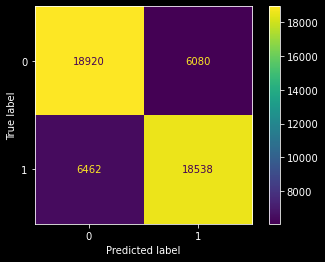

In [86]:
predicted_LR_tfidf = model_LR_tfidf.predict(X["val"]) # prédiction
cm_LR_tfidf = confusion_matrix(y["val"], predicted_LR_tfidf)
ConfusionMatrixDisplay(cm_LR_tfidf).plot()

#### Scores

In [87]:
accuracy_LR_tfidf = model_LR_tfidf.score(X["val"], y["val"])
print("Accuracy : {}".format(accuracy_LR_tfidf))
print(classification_report(y["val"], predicted_LR_tfidf))

Accuracy : 0.74916
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     25000
           1       0.75      0.74      0.75     25000

    accuracy                           0.75     50000
   macro avg       0.75      0.75      0.75     50000
weighted avg       0.75      0.75      0.75     50000



## Régression logistique avec tweets nettoyés et lemmatisés

In [88]:
model_tfidf_lem = TfidfVectorizer()
X_tfidf_lem = model_tfidf_lem.fit_transform(X_lem["train_smpl"])

In [89]:
model_LR_lem = LogisticRegression(random_state=seed)
model_LR_tfidf_lem = Pipeline(
    [
        ("tfidf", model_tfidf_lem),
        ("clf", model_LR_lem)
    ]
)
model_LR_tfidf_lem.fit(X_lem["train_smpl"], y["train_smpl"])

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=1))])

In [90]:
save_to_file(sav_path, "model_LR_tfidf_lem.sav", model_LR_tfidf_lem)

### Evaluation

#### Matrice de confusion

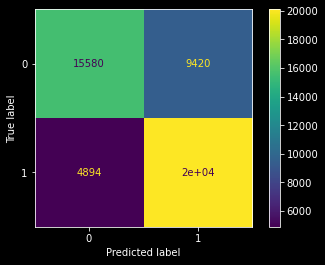

In [91]:
predicted_LR_tfidf_lem = model_LR_tfidf_lem.predict(X["val"]) # prédiction
cm_LR_tfidf_lem = confusion_matrix(y["val"], predicted_LR_tfidf_lem)
ConfusionMatrixDisplay(cm_LR_tfidf_lem).plot()

#### Scores

In [92]:
accuracy_LR_tfidf_lem = model_LR_tfidf_lem.score(X_lem["val"], y["val"])
print("Accuracy : {}".format(accuracy_LR_tfidf_lem))

print(classification_report(y["val"], predicted_LR_tfidf_lem))

Accuracy : 0.75302
              precision    recall  f1-score   support

           0       0.76      0.62      0.69     25000
           1       0.68      0.80      0.74     25000

    accuracy                           0.71     50000
   macro avg       0.72      0.71      0.71     50000
weighted avg       0.72      0.71      0.71     50000



## Deep Learning

### Embedding GloVe

Pour l'approche deep learning, nous utiliserons GloVe comme méthode de plongement de mot.

La méthode GloVe repose sur l'idée que l'on peut dériver des relations sémantiques entre les mots à partir de la matrice de co-occurence. Cette technique de vecteur de mots exploite à la fois les statistiques globales et locales d'un corpus afin de proposer une fonction de perte qui utilise les deux.

In [93]:
def load_glove(url):
    glove_embeddings = dict()
    with open(url, encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            glove_embeddings[word] = coefs
        file.close()
    return glove_embeddings

In [94]:
glove_embeddings = load_glove("./GloVe/glove.6B.300d.txt")

##### Construction du dictionnaire pour le corpus d'entraînement

Keras nous permet de définir un token "Out Of Vocab" - qui remplacera tous les mots inconnus par un token de notre choix. C'est mieux que de simplement jeter des mots inconnus, car cela indique à notre modèle qu'il y avait des informations dans ces mots.

In [95]:
def get_oov_word_index(corpus):
    oov_token ="{OOV}"
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(corpus)
    words_index = tokenizer.word_index
    return words_index

words_index = get_oov_word_index(X["train_smpl"])

In [96]:
def get_glove_embedding_matrix(dimension, glove_embeddings, words_index):
    emb_matrix = np.zeros((len(words_index)+1, dimension))
    for word, i in words_index.items():
        # obligé d'utiliser la méthode get pour 
        # obtenir un None et non une erreur en 
        # cas de mot absent du dico
        emb_vect = glove_embeddings.get(word) 
        if emb_vect is not None:
            emb_matrix[i] = emb_vect
    return emb_matrix

In [97]:
glove_emb_matrix = get_glove_embedding_matrix(300, glove_embeddings, words_index)

In [98]:
vocab_len = len(words_index)
embed_vector_len = glove_embeddings["kitten"].shape[0] # =300 --> nbre de features
max_len = 300

embedding_layer_glove = Embedding(
    input_dim = vocab_len+1,
    output_dim = embed_vector_len,
    input_length = max_len,
    weights = [glove_emb_matrix],
    trainable = False
)

### Longueur maximale des tweets

In [99]:
ls_tweets = X_lem["train_smpl"].tolist()
ls_tweets[:10]

['a page a day in the month of May be almost over what be next ? what rhyme with June ? I get nothin but I be still thinkin !',
 'be really ill x',
 'man today be a rough day .... and its only be ...',
 'ask , & quot;what part of last call do not people understand ? drink up and go home ! I need to sleep.&quot ;',
 "yay ! LOL . I actually wanna start wear some blue . so far I 've only try black and brown",
 'I miss texas too how be you ? !',
 'I start back in two week . suck but I can not wait to get my refund how have you be ?',
 "look forward to tomorrow 's shoot ! ! it will be an all DAY event ! ! absolutely thrilled , excited .. and definitely prepare",
 'I be so random when it come to my Tweets . why .. ? ? the world may never know , cause I do not know .',
 'Urgh , tirrrrrrrrrrrrrrre']

In [100]:
len_tweets = [len(tweet.split()) for tweet in ls_tweets]

In [101]:
len_max = max(len_tweets)
print("Tweet le plus long : {}".format(len_max))

Tweet le plus long : 98


In [102]:
tweet_len_sorted = pd.DataFrame(np.sort(len_tweets))
tweet_len_sorted = tweet_len_sorted.value_counts().sort_index()

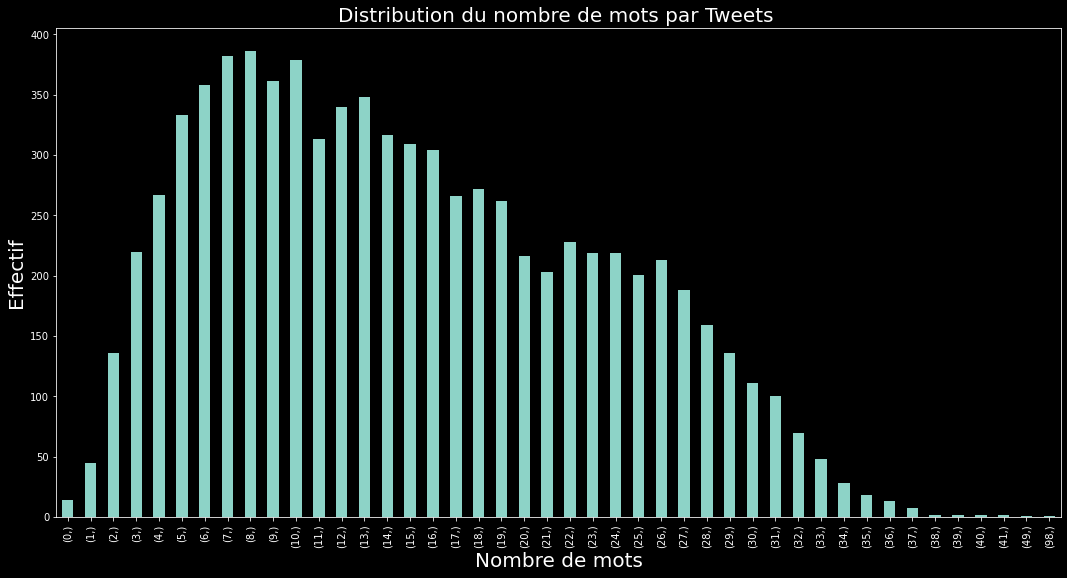

In [103]:
plt.figure(figsize=(18,9))
tweet_len_sorted.plot.bar()
plt.xlabel("Nombre de mots", fontsize=20)
plt.ylabel("Effectif", fontsize=20)
plt.title("Distribution du nombre de mots par Tweets ", fontsize=20)
plt.show()

Il y a très peu de tweets qui ont plus de 31 mots. C'est donc le nombre de mots maximum que nous choisirons.

In [104]:
# Q1 = pd.DataFrame(np.sort(len_tweets)).quantile(q=0.25)
# Q3 = pd.DataFrame(np.sort(len_tweets)).quantile(q=0.75)
# IQR = Q3 - Q1
# lim_sup = Q3 + (1.5*IQR)
# lim_sup

In [105]:
# max_wrd_len = int(lim_sup) + 1
max_wrd_len = 31 # un peu plus arbitraire qu'avec l'IQR mais donne de bien meilleurs résultats
oov_token = "{OOV}"

tokenizer = Tokenizer(oov_token = oov_token)
tokenizer.fit_on_texts(X["train_smpl"])
word_to_index = tokenizer.word_index
dictionary_size = len(word_to_index) + 1

Sauvegardons notre tokenizer

In [106]:
tokenizer_json = tokenizer.to_json()
with io.open (sav_path+"tokenizer.json", "w", encoding="utf-8") as file:
    file.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [107]:
X_seq = {}
for dataset in X:
    X_seq[dataset] = tokenizer.texts_to_sequences(X[dataset])
    print("{} : ".format(dataset))
    display(X_seq[dataset][:10])
    print("\n")

data : 


[[1386, 11, 17, 616, 1622, 798],
 [418, 27, 757],
 [3158, 1, 100, 6723, 144, 381, 1, 135],
 [4, 743, 526, 26, 38, 1, 3, 177, 6, 1],
 [78,
  10,
  311,
  8,
  112,
  194,
  128,
  880,
  67,
  5,
  1,
  6817,
  673,
  29,
  184,
  7,
  2,
  26,
  93,
  23,
  93],
 [20, 44, 1, 3, 101, 12, 105, 10309, 7, 25, 6, 2501, 55, 2168, 22, 5, 48],
 [227,
  2,
  125,
  534,
  3,
  1,
  300,
  15,
  5,
  302,
  126,
  2304,
  10,
  26,
  15,
  22,
  4,
  2574,
  19,
  428,
  22],
 [489, 321, 2427],
 [348,
  206,
  886,
  130,
  25,
  586,
  29,
  9,
  85,
  127,
  85,
  97,
  224,
  84,
  11179,
  1494,
  1],
 [2172, 2043, 31, 1, 1, 485, 11899, 9, 4, 3729, 1, 13, 1]]



cmp : 


[[4839, 1, 16, 13, 409, 2, 67, 3, 499, 1, 1],
 [376, 139, 31, 83, 7, 8, 245, 86, 223, 652, 97, 76, 2, 102, 8, 144, 23, 189],
 [47, 119, 15, 12, 4383],
 [2, 26, 140, 499, 542, 16, 94, 9, 17, 6, 34, 1709, 34, 3644, 50],
 [47, 5, 871, 3, 4, 456, 8, 1186, 1, 3, 668, 12],
 [8,
  125,
  33,
  10,
  64,
  264,
  14,
  53,
  8,
  74,
  50,
  2,
  40,
  17,
  30,
  4,
  48,
  23,
  895,
  7,
  1311,
  78,
  17,
  1009,
  12,
  350,
  190,
  709],
 [9, 766, 105, 73, 1536, 4329],
 [361, 31, 2, 160, 285, 3, 921, 32, 23, 8, 106, 84, 8, 621, 724],
 [418, 4, 8919, 11, 4, 1, 77, 3, 18, 5, 1, 11, 70, 4404],
 [65, 24, 43, 3, 1, 203, 45]]



val : 


[[113, 199, 18, 194, 88, 579],
 [244, 37, 70, 260, 1381, 1014, 11, 5, 219, 193, 1157, 2051, 187, 4164],
 [46, 311, 4, 257, 41, 1077],
 [337,
  3,
  8614,
  1,
  1,
  609,
  341,
  4984,
  1008,
  6,
  2335,
  1263,
  23,
  148,
  218,
  27,
  195],
 [9, 25, 164, 5, 31, 76],
 [879, 740, 2926, 6917, 1, 1, 501, 62, 5, 2539, 17, 455, 3, 141, 15, 14, 417],
 [456, 52, 45, 25, 31, 456, 29, 9, 6, 269, 5025],
 [179,
  143,
  263,
  168,
  1,
  1,
  7758,
  14,
  42,
  2,
  159,
  499,
  5,
  3085,
  21,
  2,
  63,
  58,
  18,
  448,
  490],
 [220, 2786, 96, 485, 3586, 3400],
 [63, 137]]



train : 


[[9, 22, 49, 1, 98, 490, 16, 459],
 [9122, 47, 514, 450, 10, 26, 16, 260, 417],
 [147, 5667, 11, 4066, 510, 73, 609],
 [51, 52, 4, 878, 8356, 3, 4, 1952, 28, 23, 909],
 [2, 102, 2, 124, 41, 8, 235, 18, 3, 114, 3, 2882, 4092, 46, 1661],
 [118, 93, 10675, 73, 389, 2157, 303, 366, 2547, 38, 1, 268, 51, 12, 5, 224],
 [592, 1, 9515, 333, 47, 5, 247, 1567],
 [217,
  2687,
  35,
  462,
  5,
  2687,
  109,
  149,
  208,
  16,
  281,
  47,
  11769,
  14,
  12,
  4,
  1,
  54,
  440,
  27,
  350,
  1382],
 [201, 3, 33, 6, 389, 154, 106, 1364, 4, 3650, 104, 1, 5, 117, 154, 2809],
 [473, 8, 1510, 132, 269, 7, 4, 165, 11731, 228, 53, 649, 71, 56, 102]]



train_smpl : 


[[5,
  707,
  5,
  35,
  12,
  4,
  525,
  13,
  366,
  9,
  305,
  129,
  418,
  166,
  53,
  3006,
  23,
  611,
  2,
  44,
  1416,
  21,
  19,
  63,
  1603],
 [9, 80, 367, 175],
 [219, 45, 9, 5, 1417, 35, 7, 69, 119, 54],
 [2316,
  34,
  53,
  526,
  13,
  97,
  387,
  58,
  142,
  661,
  584,
  27,
  7,
  41,
  72,
  2,
  98,
  3,
  101,
  34],
 [221,
  50,
  2,
  306,
  159,
  261,
  1272,
  70,
  972,
  16,
  368,
  143,
  119,
  455,
  848,
  7,
  1273],
 [2, 92, 1274, 42, 75, 37, 8],
 [2,
  261,
  51,
  12,
  256,
  369,
  284,
  21,
  2,
  61,
  146,
  3,
  33,
  6,
  4575,
  75,
  18,
  8,
  107],
 [161,
  285,
  3,
  1418,
  1041,
  708,
  24,
  86,
  30,
  35,
  1156,
  638,
  3007,
  335,
  7,
  545,
  2317],
 [2,
  54,
  16,
  905,
  84,
  10,
  392,
  3,
  6,
  469,
  108,
  4,
  257,
  366,
  152,
  57,
  434,
  2,
  58,
  57],
 [1887, 4576]]



test : 


[[9, 198, 2733, 498, 62, 28, 100],
 [2, 18, 455, 542, 21, 10617, 2080, 9, 6, 464, 56, 30, 18, 178, 7503],
 [2, 211, 653, 3, 404, 5, 384, 1, 128, 181, 302, 206, 69, 1025],
 [37, 8, 43, 3, 24, 22, 4, 805, 1332, 652, 15, 611, 347],
 [83,
  271,
  2,
  18,
  848,
  658,
  386,
  7,
  47,
  4428,
  1382,
  16,
  2,
  250,
  2,
  18,
  5,
  95,
  2138,
  48,
  181,
  8],
 [315, 38, 2, 18, 638, 38, 2873, 13, 29, 1156, 21, 10, 361, 110, 36, 14],
 [113,
  9,
  2,
  1,
  148,
  5,
  1,
  15,
  178,
  1483,
  345,
  449,
  865,
  1,
  4458,
  1,
  2625,
  21,
  292,
  113,
  299,
  1,
  12,
  724,
  16,
  133],
 [297, 198, 167, 197],
 [284, 17, 19, 140, 18, 3, 567, 12, 29, 438, 312],
 [19, 1007, 22, 1, 1604, 1, 25, 3480]]

In [108]:
X_seq_light = {}
for dataset in X_light:
    X_seq_light[dataset] = tokenizer.texts_to_sequences(X_light[dataset])
    print("{} : ".format(dataset))
    display(X_seq_light[dataset][:10])
    print("\n")

data : 


[[1386, 11, 17, 616, 1622, 798],
 [1, 418, 27, 757],
 [3158, 1, 100, 6723, 144, 381, 1, 135],
 [4, 743, 526, 26, 38, 1, 3, 177, 6, 1],
 [1,
  78,
  10,
  311,
  8,
  112,
  194,
  128,
  880,
  678,
  67,
  5,
  1,
  6817,
  673,
  29,
  184,
  7,
  2,
  26,
  93,
  23,
  93],
 [20, 44, 1, 3, 101, 12, 105, 10309, 7, 25, 6, 2501, 55, 2168, 22, 5, 48],
 [227,
  2,
  125,
  534,
  3,
  1,
  300,
  15,
  5,
  302,
  126,
  2304,
  10,
  26,
  15,
  22,
  4,
  2574,
  19,
  428,
  22],
 [489, 321, 2427],
 [2591,
  1,
  348,
  206,
  886,
  130,
  25,
  586,
  29,
  9,
  85,
  127,
  85,
  97,
  224,
  84,
  11179,
  1494,
  1],
 [2172, 2043, 31, 1, 1, 485, 11899, 9, 4, 3729, 1, 13, 1]]



cmp : 


[[1, 4839, 1, 16, 13, 409, 2, 67, 3, 499, 1, 1],
 [1,
  1078,
  376,
  139,
  31,
  83,
  7,
  8,
  245,
  86,
  223,
  652,
  97,
  76,
  2,
  102,
  8,
  144,
  23,
  189],
 [1, 175, 47, 119, 15, 12, 4383],
 [2, 26, 140, 499, 542, 16, 94, 9, 17, 6, 34, 1709, 34, 3644, 50],
 [1, 1, 47, 5, 871, 3, 4, 456, 8, 1186, 1, 3, 668, 12],
 [1,
  8,
  125,
  33,
  10,
  64,
  264,
  14,
  53,
  8,
  74,
  50,
  2,
  40,
  17,
  30,
  4,
  48,
  23,
  895,
  678,
  7,
  1311,
  78,
  17,
  1009,
  12,
  350,
  190,
  709],
 [9, 766, 105, 73, 1536, 4329],
 [1, 7876, 361, 31, 2, 160, 285, 3, 921, 32, 23, 8, 106, 84, 8, 621, 724],
 [1, 418, 4, 8919, 11, 4, 1, 77, 3, 18, 5, 1, 11, 70, 4404],
 [65, 24, 43, 3, 1, 203, 45]]



val : 


[[1, 113, 199, 18, 194, 88, 579],
 [459,
  1,
  244,
  37,
  70,
  260,
  1381,
  1014,
  11,
  5,
  219,
  193,
  1157,
  2051,
  187,
  4164],
 [46, 311, 4, 257, 41, 1077],
 [337,
  3,
  8614,
  1,
  1,
  609,
  341,
  4984,
  1008,
  6,
  2335,
  1263,
  23,
  148,
  218,
  27,
  195],
 [9, 25, 164, 5, 31, 76],
 [879, 740, 2926, 6917, 1, 1, 501, 62, 5, 2539, 17, 455, 3, 141, 15, 14, 417],
 [456, 52, 45, 25, 31, 456, 29, 9, 6, 269, 5025],
 [1,
  179,
  143,
  263,
  168,
  1,
  1,
  7758,
  14,
  42,
  2,
  159,
  499,
  5,
  3085,
  21,
  2,
  63,
  58,
  18,
  448,
  490],
 [1, 220, 2786, 96, 485, 3586, 3400],
 [63, 137]]



train : 


[[9, 22, 49, 1, 98, 490, 16, 459],
 [9122, 47, 514, 450, 10, 26, 16, 260, 417],
 [147, 5667, 11, 4066, 1, 73, 609],
 [51, 52, 4, 878, 8356, 3, 4, 1952, 28, 23, 909],
 [1, 2, 102, 2, 124, 41, 8, 235, 18, 3, 114, 3, 2882, 4092, 46, 1661],
 [1,
  118,
  93,
  10675,
  73,
  389,
  2157,
  303,
  366,
  1,
  2547,
  38,
  1,
  268,
  51,
  12,
  5,
  224],
 [1, 592, 1, 9515, 333, 47, 5, 247, 1567],
 [217,
  2687,
  35,
  462,
  5,
  2687,
  109,
  149,
  208,
  16,
  281,
  47,
  11769,
  14,
  12,
  4,
  1,
  54,
  440,
  27,
  350,
  1382],
 [201, 3, 33, 6, 389, 154, 106, 1364, 4, 3650, 104, 1, 5, 117, 154, 2809],
 [2591,
  1,
  473,
  8,
  1510,
  132,
  269,
  7,
  4,
  165,
  11731,
  228,
  53,
  649,
  71,
  56,
  102]]



train_smpl : 


[[5,
  707,
  5,
  35,
  12,
  4,
  525,
  13,
  366,
  9,
  305,
  129,
  418,
  166,
  53,
  3006,
  23,
  611,
  2,
  44,
  1416,
  21,
  19,
  63,
  1603],
 [9, 80, 367, 175],
 [219, 45, 9, 5, 1417, 35, 7, 69, 119, 1],
 [2316,
  34,
  53,
  526,
  13,
  97,
  387,
  58,
  142,
  661,
  584,
  27,
  7,
  41,
  72,
  2,
  98,
  3,
  101,
  34],
 [1,
  221,
  50,
  2,
  306,
  159,
  261,
  1272,
  70,
  972,
  16,
  368,
  143,
  119,
  455,
  848,
  7,
  1273],
 [1, 2, 92, 1274, 42, 75, 37, 8],
 [1,
  2,
  261,
  51,
  12,
  256,
  369,
  284,
  21,
  2,
  61,
  146,
  3,
  33,
  6,
  4575,
  75,
  18,
  8,
  107],
 [161,
  285,
  3,
  1418,
  1041,
  708,
  24,
  86,
  30,
  35,
  1156,
  638,
  3007,
  335,
  7,
  545,
  2317],
 [2,
  54,
  16,
  905,
  84,
  10,
  392,
  3,
  6,
  469,
  108,
  4,
  257,
  366,
  152,
  57,
  434,
  2,
  58,
  57],
 [1887, 4576]]



test : 


[[9, 198, 2733, 498, 62, 28, 100],
 [1, 2, 18, 455, 542, 21, 10617, 2080, 9, 6, 464, 56, 30, 18, 178, 7503],
 [2, 211, 653, 3, 404, 5, 384, 1, 128, 181, 302, 206, 69, 1025],
 [1, 37, 8, 43, 3, 24, 22, 4, 805, 1332, 652, 15, 611, 1],
 [1,
  83,
  271,
  2,
  18,
  848,
  658,
  386,
  7,
  47,
  4428,
  1382,
  16,
  2,
  250,
  2,
  18,
  5,
  95,
  2138,
  48,
  181,
  8],
 [1, 315, 38, 2, 18, 638, 38, 2873, 13, 29, 1156, 21, 10, 361, 110, 36, 14],
 [1,
  113,
  9,
  2,
  1,
  148,
  5,
  1,
  15,
  178,
  1483,
  345,
  449,
  865,
  1,
  4458,
  1,
  2625,
  21,
  292,
  113,
  299,
  1,
  12,
  724,
  16,
  133],
 [297, 198, 167, 197],
 [284, 17, 19, 140, 18, 3, 567, 12, 29, 438, 312],
 [1, 19, 1007, 22, 1, 1604, 1, 25, 3480]]

In [109]:
X_seq_pad = {}
for dataset in X_seq:
    X_seq_pad[dataset] = pad_sequences(
        X_seq[dataset], 
#         maxlen = len_max,
        maxlen = max_wrd_len,
        padding = "post",
        truncating = "post"
    )
    print("X_seq_pad[{}] shape : {}".format(dataset, X_seq_pad[dataset].shape))

X_seq_pad[data] shape : (1548400, 31)
X_seq_pad[cmp] shape : (1600, 31)
X_seq_pad[val] shape : (50000, 31)
X_seq_pad[train] shape : (1238720, 31)
X_seq_pad[train_smpl] shape : (8000, 31)
X_seq_pad[test] shape : (309680, 31)


In [110]:
X_seq_pad_light = {}
for dataset in X_seq_light:
    X_seq_pad_light[dataset] = pad_sequences(
        X_seq_light[dataset], 
#         maxlen = len_max,
        maxlen = max_wrd_len,
        padding = "post",
        truncating = "post"
    )
    print("X_seq_pad_light[{}] shape : {}".format(dataset, X_seq_pad_light[dataset].shape))

X_seq_pad_light[data] shape : (1548400, 31)
X_seq_pad_light[cmp] shape : (1600, 31)
X_seq_pad_light[val] shape : (50000, 31)
X_seq_pad_light[train] shape : (1238720, 31)
X_seq_pad_light[train_smpl] shape : (8000, 31)
X_seq_pad_light[test] shape : (309680, 31)


In [111]:
save_to_file(sav_path, "X_seq_pad.sav", X_seq_pad)
save_to_file(sav_path, "X_seq_pad_light.sav", X_seq_pad_light)

#### FastText

In [112]:
ft = FastText(
    vector_size = 10,
    window = 3,
    min_count = 1
)
ft.build_vocab(
    corpus_iterable = X_seq["train"]
)
ft.train(
    corpus_iterable = X_seq["train"],
    total_examples = len(X_seq["train"]),
    epochs = 10
)

(113584534, 155840730)

In [113]:
fasttext_emb_matrix = np.zeros((vocab_len+1, 10))
for w, i in words_index.items():
    fasttext_emb_matrix[i] = ft.wv[w]

#### Chronométrer un modèle

In [114]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

### Modélisations

In [116]:
models = {}
history = {}
times = {}

nb_epoch = 10
batch_size = 128
nb_neurons = 50
# nb_neurons = 64
emb_dim = 300

embeddings = {
    "default" : Embedding(
                    input_dim = dictionary_size, 
                    output_dim = emb_dim, 
                    input_length = max_wrd_len
                ),
    "glove" :  Embedding(
                    input_dim = dictionary_size, 
                    output_dim = embed_vector_len,
                    weights = [glove_emb_matrix],
                    input_length = max_wrd_len,
                    trainable = False
               ),
    "fasttext" : Embedding(
                    input_dim = dictionary_size,
                    output_dim = ft.vector_size,
                    weights = [fasttext_emb_matrix],
                    input_length = max_wrd_len,
                    trainable = False
                )
}

cust_layers = {
    "RNN": {
        "recurrent": SimpleRNN(
                units=nb_neurons
            ),
        "embedding": embeddings["default"]
    },
    "RNN_GLOVE": {
        "recurrent": SimpleRNN(
                units=nb_neurons
            ),
        "embedding": embeddings["glove"]
    },
    "RNN_FASTTEXT": {
        "recurrent": SimpleRNN(
                units=nb_neurons
            ),
        "embedding": embeddings["fasttext"]
    },
    "LSTM": {
        "recurrent": LSTM(
                units=nb_neurons
            ),
        "embedding": embeddings["default"]
    },
    "LSTM_GLOVE": {
        "recurrent": LSTM(
                units=nb_neurons
            ),
        "embedding": embeddings["glove"]
    },
    "LSTM_FASTTEXT": {
        "recurrent": LSTM(
                units=nb_neurons
            ),
        "embedding": embeddings["fasttext"]
    },
    "GRU": {
        "recurrent": GRU(
                units = nb_neurons
            ),
        "embedding": embeddings["default"]
    },
    "GRU_GLOVE": {
        "recurrent": GRU(
                units = nb_neurons
            ),
        "embedding": embeddings["glove"]
    },
    "GRU_FASTTEXT": {
        "recurrent": GRU(
                units = nb_neurons
            ),
        "embedding": embeddings["fasttext"]
    },
    "BLSTM": {
        "recurrent": Bidirectional(
                LSTM(
                    units=nb_neurons
                )
            ),
        "embedding": embeddings["default"]
    },
    "BLSTM_GLOVE": {
        "recurrent": Bidirectional(
                LSTM(
                    units=nb_neurons
                )
            ),
        "embedding": embeddings["glove"]
    },
    "BLSTM_FASTTEXT": {
        "recurrent": Bidirectional(
                LSTM(
                    units=nb_neurons
                )
            ),
        "embedding": embeddings["fasttext"]
    },
    "BGRU": {
        "recurrent": Bidirectional(
                GRU(
                    units=nb_neurons
                )
            ),
        "embedding": embeddings["default"]
    },
    "BGRU_GLOVE": {
        "recurrent": Bidirectional(
                GRU(
                    units=nb_neurons
                )
            ),
        "embedding": embeddings["glove"]
    },
    "BGRU_FASTTEXT": {
        "recurrent": Bidirectional(
                GRU(
                    units=nb_neurons
                )
            ),
        "embedding": embeddings["default"]
    }
}

descriptions = {
    "RNN" : "Recurrent Neural Network",
    "RNN_GLOVE" : "Recurrent Neural Network avec embedding GloVe",
    "RNN_FASTTEXT" : "Recurrent Neural Network avec embedding fastText",
    "LSTM": "Long Short-Term Memory",
    "LSTM_GLOVE": "Long Short-Term Memory avec embedding GloVe",
    "LSTM_FASTTEXT": "Long Short-Term Memory avec embedding fastText",
    "GRU" : "Gated Recurrent Unit",
    "GRU_GLOVE" : "Gated Recurrent Unit avec embedding GloVe",
    "GRU_FASTTEXT" : "Gated Recurrent Unit avec embedding fastText",
    "BLSTM": "Bidirectional Long Short-Term Memory",
    "BLSTM_GLOVE": "Bidirectional Long Short-Term Memory avec embedding GloVe",
    "BLSTM_FASTTEXT": "Bidirectional Long Short-Term Memory avec embedding fastText",
    "BGRU" : "Bidirectional Gated Recurrent Unit",
    "BGRU_GLOVE" : "Bidirectional Gated Recurrent Unit avec embedding GloVe",
    "BGRU_FASTTEXT" : "Bidirectional Gated Recurrent Unit avec embedding fastText"
}

In [117]:
def build_model(emb, recurrent, architecture):
    model = Sequential()
    # embedding
    model.add(
        emb
    )
    # recurrent
    model.add(
        recurrent
    )
    # dense
    if architecture == "A":
        model.add(
            Dense(
                units=50,
                activation="relu"
            )
        )
        model.add(
            Dense(
                units=1, 
            )
        )
    elif architecture == "B":
        model.add(
            Dense(
                units=1, 
                activation='sigmoid'
            )
        )
    model.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    return model


def build_and_run_all(
    cust_layers, 
    embeddings, 
    descriptions, 
    X, 
    y, 
    X_val, 
    y_val,
    batch_size,
    nb_epoch,
    time_callback
):
    models = {}
    history = {}
    times = {}
    max_accuracies = {}
    best_times = {}
    classification_reports = {}
    AB = {}
    for architecture in ["A", "B"]:
        AB[architecture] = {
            "model": {},
            "history": {},
            "times": {},
            "max_accuracy": {},
            "best_time": {},
            "classification_report": {}
        }
    
    for model_type in cust_layers:
        for architecture in ["A", "B"]:
            display(HTML("<h1>{} - {}</h1>".format(descriptions[model_type], architecture)))
            AB[architecture]["model"] = build_model(
                emb = cust_layers[model_type]["embedding"],
                recurrent = cust_layers[model_type]["recurrent"],
                architecture = architecture
            )

            display(HTML("<h2>{} : Architecture {}</h2>".format(model_type, architecture)))
            AB[architecture]["model"].summary()

            display(HTML("<h2>{} : Entraînement {}</h2>".format(model_type, architecture)))
            AB[architecture]["history"] = AB[architecture]["model"].fit(
                X,
                y,
                batch_size = batch_size,
                epochs=nb_epoch,
                validation_data = (X_val, y_val),
                callbacks = time_callback
            )

            AB[architecture]["times"] = time_callback.times

            display(AB[architecture]["history"])
            plot_metrics(AB[architecture]["history"], model_type)

            display(HTML("<h2>{} : Meilleur score {}</h2>".format(model_type, architecture)))

            AB[architecture]["max_accuracy"] = max(
                AB[architecture]["history"].history["val_accuracy"]
            )
            print("{} - max accuracy : {}".format(
                model_type,
                AB[architecture]["max_accuracy"]
            ))

            AB[architecture]["best_time"] = AB[architecture]["times"][np.argmax(
                AB[architecture]["history"].history["val_accuracy"])]
            print("{} - best time : {} \n".format(
                model_type,
                AB[architecture]["best_time"]
            ))
    
        # sélection de la meilleure architecture pour le modèle
        acc_comparison = []
        for architecture in ["A", "B"]:
            acc_comparison.append(AB[architecture]["max_accuracy"])
        best_arch = ["A", "B"][acc_comparison.index(max(acc_comparison))]

        display(
            HTML(
                "<h2>{} : Meilleure architecture</h2>".format(model_type)
            )
        )
        print("l'architecture {} a un meilleur score d'accuracy (accuracy = {})".format(
            best_arch,
            AB[best_arch]["max_accuracy"]
        ))
        models[model_type] = AB[best_arch]["model"]
        history[model_type] = AB[best_arch]["history"]
        times[model_type] = AB[best_arch]["times"]
        max_accuracies[model_type] = AB[best_arch]["max_accuracy"]
        best_times[model_type] = AB[best_arch]["best_time"]
    
        # Evaluation
        display(HTML("<h2>Evaluation</h2>"))
        display(HTML("<h3>Matrice de confusion<h3>"))
        predicted = (models[model_type].predict(X_val) > 0.5).astype("int32")
        cm = confusion_matrix(y_val, predicted)
        cm = pd.DataFrame(cm, range(2), range(2))
        plt.figure(figsize = (10,10))
        sns.heatmap(cm, annot=True, annot_kws={"size": 12})
        plt.title("Matrice de confusion du modèle {}".format(model_type))
        plt.show()  

        display(HTML("<h3>Scores<h3>"))
        classification_reports[model_type] = classification_report(y_val, predicted)
        print(classification_reports[model_type])
    
    display(HTML("<h1>Sélection du meilleur modèle</h1>"))
    df_accuracies = pd.DataFrame.from_dict(max_accuracies, orient="index", columns=["accuracy"])
    df_times = pd.DataFrame.from_dict(best_times, orient="index", columns=["time"])
    display(df_accuracies.sort_values(by="accuracy", ascending=False))
    display(df_times.sort_values(by="time", ascending=True))
    
    # plot accuracy
    ax = df_accuracies.sort_values(by="accuracy", ascending=False).plot.bar(
        figsize=(18,9), 
        legend = False
    )
    ax.bar_label(ax.containers[0])
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Modèle")
    ax.set_title("Classement des modèles par score d'accuracy")
    plt.show()
    
    # plot temps d'éxécution
    ax = df_times.sort_values(by="time", ascending=True).plot.bar(
        figsize=(18,9), 
        legend = False
    )
    ax.bar_label(ax.containers[0])
    ax.set_ylabel("time")
    ax.set_xlabel("Modèle")
    ax.set_title("Classement des modèles par temps d'exécution")
    plt.show()
    
    display(HTML("<h2>Meilleur modèle : </h2>"))
    display(
            df_accuracies.sort_values(
            by = "accuracy",
            ascending = False
        ).iloc[0]
    )
    
    return models, history, times, max_accuracies, best_times, classification_report

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                17550     
                                                                 
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,606,651
Trainable params: 3,606,651
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 6s 89ms/step - loss: 0.9166 - accuracy: 0.5107 - val_loss: 0.6960 - val_accuracy: 0.5011
Epoch 2/10
63/63 [==============================] - 6s 90ms/step - loss: 0.4822 - accuracy: 0.8036 - val_loss: 1.0730 - val_accuracy: 0.5630
Epoch 3/10
63/63 [==============================] - 6s 91ms/step - loss: 0.2408 - accuracy: 0.9291 - val_loss: 1.9517 - val_accuracy: 0.5937
Epoch 4/10
63/63 [==============================] - 6s 94ms/step - loss: 0.1500 - accuracy: 0.9688 - val_loss: 2.8052 - val_accuracy: 0.5906
Epoch 5/10
63/63 [==============================] - 6s 95ms/step - loss: 0.0892 - accuracy: 0.9858 - val_loss: 3.1120 - val_accuracy: 0.5921
Epoch 6/10
63/63 [==============================] - 6s 97ms/step - loss: 0.2420 - accuracy: 0.9521 - val_loss: 1.9657 - val_accuracy: 0.5619
Epoch 7/10
63/63 [==============================] - 6s 100ms/step - loss: 0.2880 - accuracy: 0.9111 - val_loss: 2.3321 - val_accuracy: 0.5924
Epoch 8/10
6

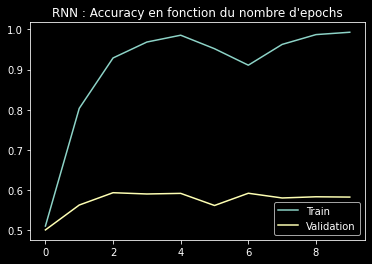

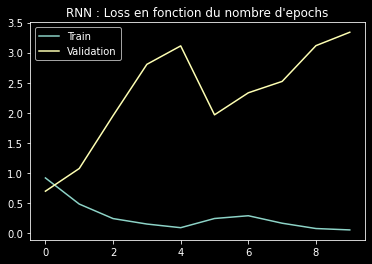

RNN - max accuracy : 0.593720018863678
RNN - best time : 5.685500144958496 



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                17550     
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,604,101
Trainable params: 3,604,101
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 6s 92ms/step - loss: 0.2010 - accuracy: 0.9626 - val_loss: 0.8831 - val_accuracy: 0.5856
Epoch 2/10
63/63 [==============================] - 5s 88ms/step - loss: 0.0484 - accuracy: 0.9909 - val_loss: 1.0128 - val_accuracy: 0.5838
Epoch 3/10
63/63 [==============================] - 6s 90ms/step - loss: 0.0294 - accuracy: 0.9939 - val_loss: 1.0873 - val_accuracy: 0.5847
Epoch 4/10
63/63 [==============================] - 6s 89ms/step - loss: 0.0232 - accuracy: 0.9945 - val_loss: 1.1436 - val_accuracy: 0.5865
Epoch 5/10
63/63 [==============================] - 6s 89ms/step - loss: 0.0135 - accuracy: 0.9970 - val_loss: 1.2416 - val_accuracy: 0.5740
Epoch 6/10
63/63 [==============================] - 6s 89ms/step - loss: 0.0097 - accuracy: 0.9975 - val_loss: 1.3015 - val_accuracy: 0.5763
Epoch 7/10
63/63 [==============================] - 6s 89ms/step - loss: 0.0108 - accuracy: 0.9967 - val_loss: 1.3714 - val_accuracy: 0.5718
Epoch 8/10
63

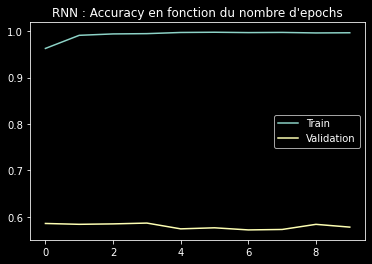

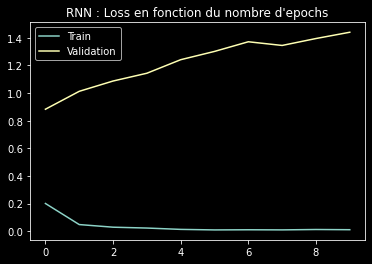

RNN - max accuracy : 0.5864999890327454
RNN - best time : 5.540000677108765 



l'architecture A a un meilleur score d'accuracy (accuracy = 0.593720018863678)


1563/1563 [==============================] - 4s 2ms/step


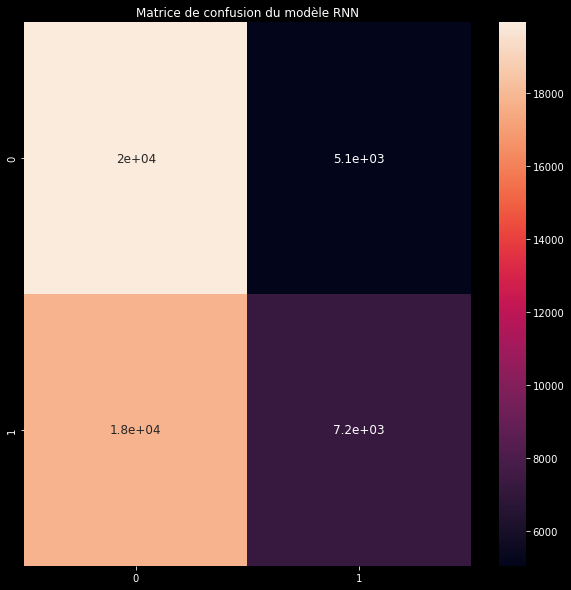

              precision    recall  f1-score   support

           0       0.53      0.80      0.64     25000
           1       0.59      0.29      0.39     25000

    accuracy                           0.54     50000
   macro avg       0.56      0.54      0.51     50000
weighted avg       0.56      0.54      0.51     50000



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 50)                17550     
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,606,651
Trainable params: 20,151
Non-trainable params: 3,586,500
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 4s 63ms/step - loss: 1.0643 - accuracy: 0.5106 - val_loss: 0.7008 - val_accuracy: 0.5042
Epoch 2/10
63/63 [==============================] - 4s 61ms/step - loss: 0.6993 - accuracy: 0.5008 - val_loss: 0.7007 - val_accuracy: 0.4968
Epoch 3/10
63/63 [==============================] - 4s 64ms/step - loss: 0.6956 - accuracy: 0.5011 - val_loss: 0.6957 - val_accuracy: 0.5086
Epoch 4/10
63/63 [==============================] - 4s 62ms/step - loss: 0.6937 - accuracy: 0.5101 - val_loss: 0.6951 - val_accuracy: 0.5100
Epoch 5/10
63/63 [==============================] - 4s 63ms/step - loss: 0.6925 - accuracy: 0.5136 - val_loss: 0.6954 - val_accuracy: 0.5147
Epoch 6/10
63/63 [==============================] - 4s 63ms/step - loss: 0.6897 - accuracy: 0.5163 - val_loss: 0.6953 - val_accuracy: 0.5169
Epoch 7/10
63/63 [==============================] - 4s 61ms/step - loss: 0.6873 - accuracy: 0.5210 - val_loss: 0.6959 - val_accuracy: 0.5220
Epoch 8/10
63

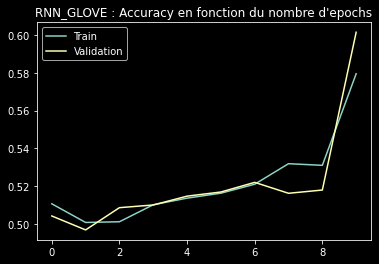

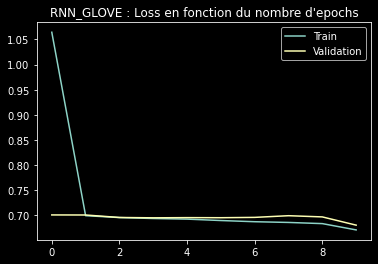

RNN_GLOVE - max accuracy : 0.6014800071716309
RNN_GLOVE - best time : 3.8675012588500977 



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 50)                17550     
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,604,101
Trainable params: 17,601
Non-trainable params: 3,586,500
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 4s 60ms/step - loss: 0.6366 - accuracy: 0.6392 - val_loss: 0.6213 - val_accuracy: 0.6710
Epoch 2/10
63/63 [==============================] - 4s 57ms/step - loss: 0.5887 - accuracy: 0.7038 - val_loss: 0.5914 - val_accuracy: 0.6936
Epoch 3/10
63/63 [==============================] - 4s 58ms/step - loss: 0.5528 - accuracy: 0.7329 - val_loss: 0.5883 - val_accuracy: 0.7027
Epoch 4/10
63/63 [==============================] - 4s 57ms/step - loss: 0.5338 - accuracy: 0.7439 - val_loss: 0.6018 - val_accuracy: 0.6944
Epoch 5/10
63/63 [==============================] - 4s 57ms/step - loss: 0.5260 - accuracy: 0.7500 - val_loss: 0.5905 - val_accuracy: 0.7073
Epoch 6/10
63/63 [==============================] - 4s 61ms/step - loss: 0.5102 - accuracy: 0.7660 - val_loss: 0.5904 - val_accuracy: 0.7024
Epoch 7/10
63/63 [==============================] - 4s 63ms/step - loss: 0.4744 - accuracy: 0.7872 - val_loss: 0.6041 - val_accuracy: 0.7037
Epoch 8/10
63

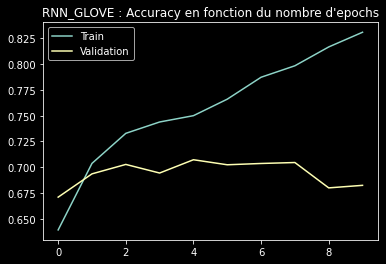

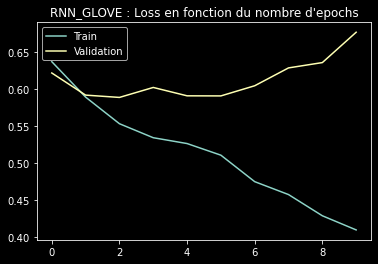

RNN_GLOVE - max accuracy : 0.7072799801826477
RNN_GLOVE - best time : 3.5249991416931152 



l'architecture B a un meilleur score d'accuracy (accuracy = 0.7072799801826477)


1563/1563 [==============================] - 4s 2ms/step


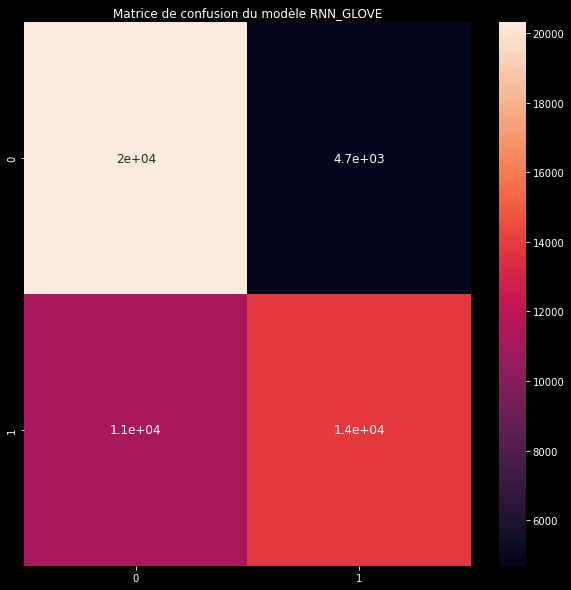

              precision    recall  f1-score   support

           0       0.64      0.81      0.72     25000
           1       0.75      0.55      0.64     25000

    accuracy                           0.68     50000
   macro avg       0.70      0.68      0.68     50000
weighted avg       0.70      0.68      0.68     50000



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 31, 10)            119550    
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                3050      
                                                                 
 dense_18 (Dense)            (None, 50)                2550      
                                                                 
 dense_19 (Dense)            (None, 1)                 51        
                                                                 
Total params: 125,201
Trainable params: 5,651
Non-trainable params: 119,550
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 1s 13ms/step - loss: 1.1435 - accuracy: 0.5036 - val_loss: 0.7030 - val_accuracy: 0.5047
Epoch 2/10
63/63 [==============================] - 1s 11ms/step - loss: 0.7019 - accuracy: 0.5002 - val_loss: 0.6978 - val_accuracy: 0.5036
Epoch 3/10
63/63 [==============================] - 1s 11ms/step - loss: 0.6999 - accuracy: 0.5009 - val_loss: 0.6957 - val_accuracy: 0.5104
Epoch 4/10
63/63 [==============================] - 1s 11ms/step - loss: 0.6969 - accuracy: 0.4961 - val_loss: 0.6957 - val_accuracy: 0.5089
Epoch 5/10
63/63 [==============================] - 1s 11ms/step - loss: 0.6974 - accuracy: 0.5030 - val_loss: 0.6985 - val_accuracy: 0.4994
Epoch 6/10
63/63 [==============================] - 1s 11ms/step - loss: 0.6965 - accuracy: 0.4971 - val_loss: 0.6958 - val_accuracy: 0.4947
Epoch 7/10
63/63 [==============================] - 1s 11ms/step - loss: 0.6968 - accuracy: 0.5013 - val_loss: 0.6954 - val_accuracy: 0.4966
Epoch 8/10
63

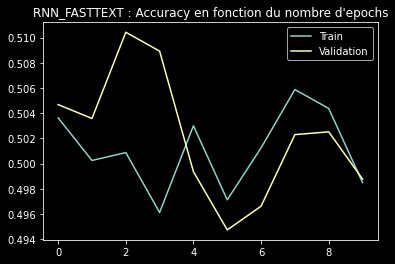

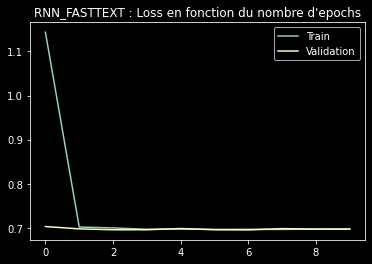

RNN_FASTTEXT - max accuracy : 0.510420024394989
RNN_FASTTEXT - best time : 0.6814999580383301 



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 31, 10)            119550    
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                3050      
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 122,651
Trainable params: 3,101
Non-trainable params: 119,550
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 1s 12ms/step - loss: 0.6955 - accuracy: 0.5077 - val_loss: 0.6947 - val_accuracy: 0.5005
Epoch 2/10
63/63 [==============================] - 1s 10ms/step - loss: 0.6939 - accuracy: 0.5131 - val_loss: 0.6940 - val_accuracy: 0.4965
Epoch 3/10
63/63 [==============================] - 1s 11ms/step - loss: 0.6899 - accuracy: 0.5312 - val_loss: 0.6917 - val_accuracy: 0.5385
Epoch 4/10
63/63 [==============================] - 1s 11ms/step - loss: 0.6857 - accuracy: 0.5526 - val_loss: 0.6905 - val_accuracy: 0.5427
Epoch 5/10
63/63 [==============================] - 1s 11ms/step - loss: 0.6852 - accuracy: 0.5526 - val_loss: 0.6875 - val_accuracy: 0.5469
Epoch 6/10
63/63 [==============================] - 1s 11ms/step - loss: 0.6814 - accuracy: 0.5706 - val_loss: 0.6902 - val_accuracy: 0.5382
Epoch 7/10
63/63 [==============================] - 1s 11ms/step - loss: 0.6822 - accuracy: 0.5651 - val_loss: 0.6878 - val_accuracy: 0.5497
Epoch 8/10
63

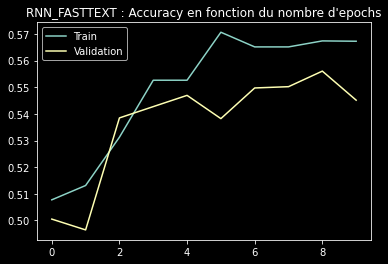

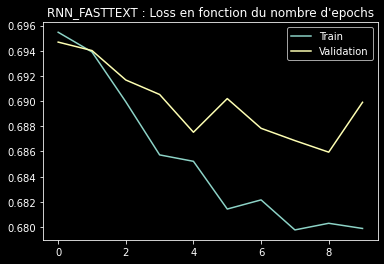

RNN_FASTTEXT - max accuracy : 0.5560399889945984
RNN_FASTTEXT - best time : 0.6635012626647949 



l'architecture B a un meilleur score d'accuracy (accuracy = 0.5560399889945984)


1563/1563 [==============================] - 1s 909us/step


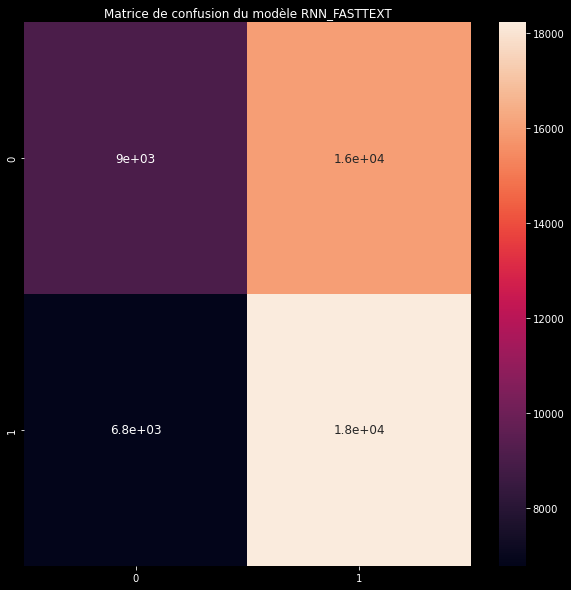

              precision    recall  f1-score   support

           0       0.57      0.36      0.44     25000
           1       0.53      0.73      0.62     25000

    accuracy                           0.55     50000
   macro avg       0.55      0.55      0.53     50000
weighted avg       0.55      0.55      0.53     50000



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 lstm_6 (LSTM)               (None, 50)                70200     
                                                                 
 dense_21 (Dense)            (None, 50)                2550      
                                                                 
 dense_22 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,659,301
Trainable params: 3,659,301
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 7s 95ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 6s 90ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 3/10
63/63 [==============================] - 6s 91ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 4/10
63/63 [==============================] - 6s 92ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/10
63/63 [==============================] - 6s 92ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 6/10
63/63 [==============================] - 6s 91ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 7/10
63/63 [==============================] - 6s 91ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 8/10
63

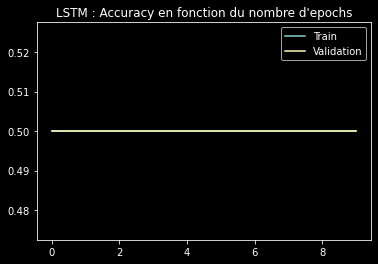

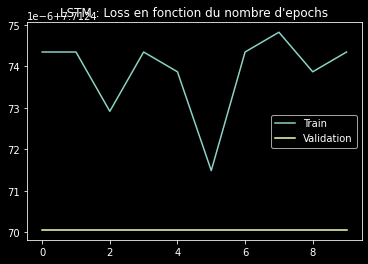

LSTM - max accuracy : 0.5
LSTM - best time : 7.032999038696289 



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 lstm_6 (LSTM)               (None, 50)                70200     
                                                                 
 dense_23 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,656,751
Trainable params: 3,656,751
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 7s 96ms/step - loss: 0.6567 - accuracy: 0.5814 - val_loss: 0.5970 - val_accuracy: 0.6911
Epoch 2/10
63/63 [==============================] - 6s 90ms/step - loss: 0.4511 - accuracy: 0.8006 - val_loss: 0.5701 - val_accuracy: 0.7404
Epoch 3/10
63/63 [==============================] - 6s 90ms/step - loss: 0.2870 - accuracy: 0.8917 - val_loss: 0.6631 - val_accuracy: 0.7267
Epoch 4/10
63/63 [==============================] - 6s 91ms/step - loss: 0.1938 - accuracy: 0.9312 - val_loss: 0.7110 - val_accuracy: 0.7152
Epoch 5/10
63/63 [==============================] - 6s 92ms/step - loss: 0.1514 - accuracy: 0.9524 - val_loss: 0.7510 - val_accuracy: 0.7153
Epoch 6/10
63/63 [==============================] - 6s 92ms/step - loss: 0.1227 - accuracy: 0.9597 - val_loss: 0.8527 - val_accuracy: 0.7077
Epoch 7/10
63/63 [==============================] - 6s 91ms/step - loss: 0.0959 - accuracy: 0.9691 - val_loss: 0.9792 - val_accuracy: 0.7077
Epoch 8/10
63

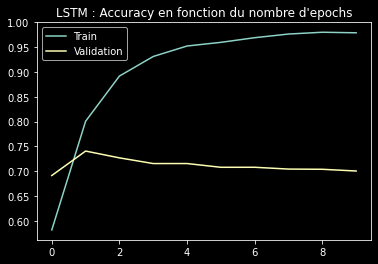

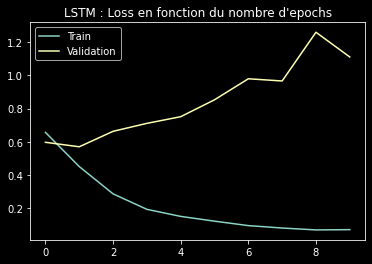

LSTM - max accuracy : 0.7404400110244751
LSTM - best time : 5.62149977684021 



l'architecture B a un meilleur score d'accuracy (accuracy = 0.7404400110244751)


1563/1563 [==============================] - 13s 8ms/step


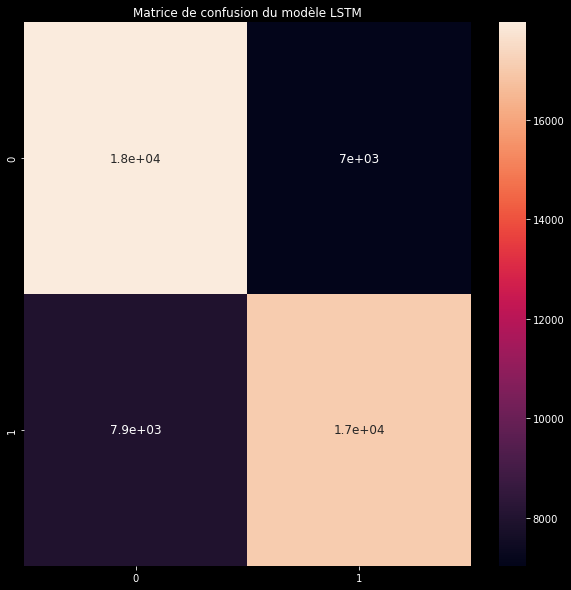

              precision    recall  f1-score   support

           0       0.69      0.72      0.71     25000
           1       0.71      0.68      0.69     25000

    accuracy                           0.70     50000
   macro avg       0.70      0.70      0.70     50000
weighted avg       0.70      0.70      0.70     50000



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 lstm_7 (LSTM)               (None, 50)                70200     
                                                                 
 dense_24 (Dense)            (None, 50)                2550      
                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,659,301
Trainable params: 72,801
Non-trainable params: 3,586,500
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 8s 104ms/step - loss: 0.9286 - accuracy: 0.5051 - val_loss: 0.6990 - val_accuracy: 0.5332
Epoch 2/10
63/63 [==============================] - 6s 100ms/step - loss: 0.6532 - accuracy: 0.6245 - val_loss: 0.5988 - val_accuracy: 0.6819
Epoch 3/10
63/63 [==============================] - 6s 99ms/step - loss: 0.5816 - accuracy: 0.7036 - val_loss: 0.5732 - val_accuracy: 0.7130
Epoch 4/10
63/63 [==============================] - 6s 100ms/step - loss: 0.5553 - accuracy: 0.7211 - val_loss: 0.5465 - val_accuracy: 0.7223
Epoch 5/10
63/63 [==============================] - 6s 100ms/step - loss: 0.5224 - accuracy: 0.7389 - val_loss: 0.5402 - val_accuracy: 0.7292
Epoch 6/10
63/63 [==============================] - 6s 100ms/step - loss: 0.6163 - accuracy: 0.6511 - val_loss: 0.5610 - val_accuracy: 0.7218
Epoch 7/10
63/63 [==============================] - 6s 100ms/step - loss: 0.5196 - accuracy: 0.7426 - val_loss: 0.5480 - val_accuracy: 0.7160
Epoch 8

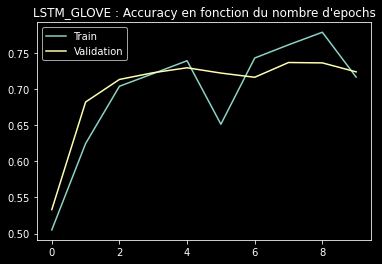

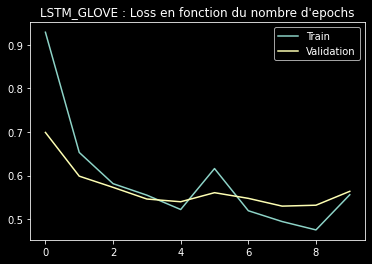

LSTM_GLOVE - max accuracy : 0.7364199757575989
LSTM_GLOVE - best time : 6.206498861312866 



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 lstm_7 (LSTM)               (None, 50)                70200     
                                                                 
 dense_26 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,656,751
Trainable params: 70,251
Non-trainable params: 3,586,500
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 7s 101ms/step - loss: 0.5163 - accuracy: 0.7536 - val_loss: 0.5319 - val_accuracy: 0.7380
Epoch 2/10
63/63 [==============================] - 6s 96ms/step - loss: 0.4527 - accuracy: 0.7879 - val_loss: 0.5503 - val_accuracy: 0.7386
Epoch 3/10
63/63 [==============================] - 6s 96ms/step - loss: 0.4256 - accuracy: 0.8052 - val_loss: 0.5473 - val_accuracy: 0.7383
Epoch 4/10
63/63 [==============================] - 6s 98ms/step - loss: 0.4039 - accuracy: 0.8171 - val_loss: 0.5439 - val_accuracy: 0.7384
Epoch 5/10
63/63 [==============================] - 6s 96ms/step - loss: 0.3733 - accuracy: 0.8361 - val_loss: 0.5546 - val_accuracy: 0.7409
Epoch 6/10
63/63 [==============================] - 6s 96ms/step - loss: 0.3629 - accuracy: 0.8414 - val_loss: 0.5714 - val_accuracy: 0.7464
Epoch 7/10
63/63 [==============================] - 6s 97ms/step - loss: 0.3365 - accuracy: 0.8569 - val_loss: 0.5865 - val_accuracy: 0.7425
Epoch 8/10
6

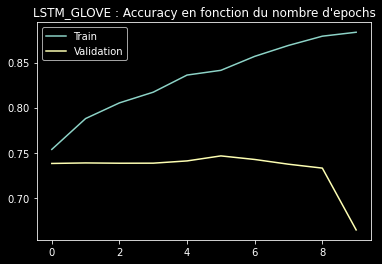

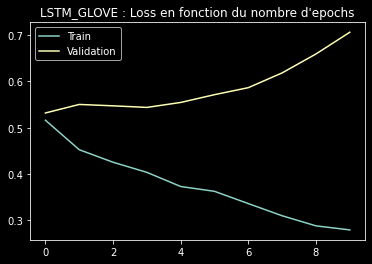

LSTM_GLOVE - max accuracy : 0.7464200258255005
LSTM_GLOVE - best time : 6.010999441146851 



l'architecture B a un meilleur score d'accuracy (accuracy = 0.7464200258255005)


1563/1563 [==============================] - 19s 12ms/step


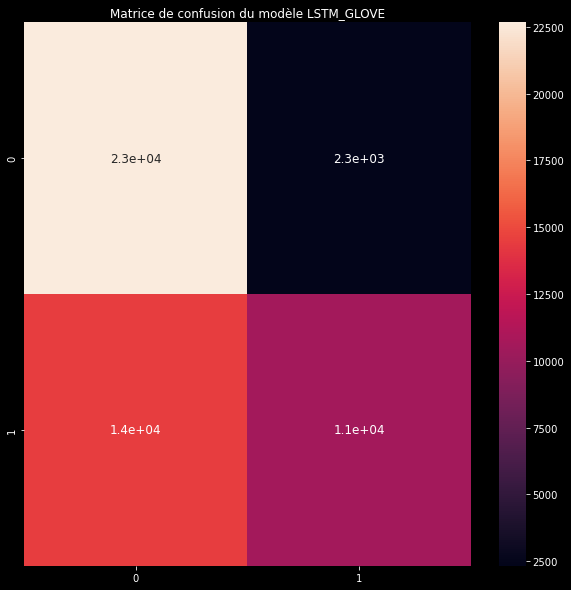

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     25000
           1       0.82      0.42      0.56     25000

    accuracy                           0.66     50000
   macro avg       0.71      0.66      0.64     50000
weighted avg       0.71      0.66      0.64     50000



Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 31, 10)            119550    
                                                                 
 lstm_8 (LSTM)               (None, 50)                12200     
                                                                 
 dense_27 (Dense)            (None, 50)                2550      
                                                                 
 dense_28 (Dense)            (None, 1)                 51        
                                                                 
Total params: 134,351
Trainable params: 14,801
Non-trainable params: 119,550
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 4s 54ms/step - loss: 1.1537 - accuracy: 0.4970 - val_loss: 0.7215 - val_accuracy: 0.5137
Epoch 2/10
63/63 [==============================] - 3s 48ms/step - loss: 0.7174 - accuracy: 0.5144 - val_loss: 0.7064 - val_accuracy: 0.5013
Epoch 3/10
63/63 [==============================] - 3s 48ms/step - loss: 0.7200 - accuracy: 0.5064 - val_loss: 0.6911 - val_accuracy: 0.5353
Epoch 4/10
63/63 [==============================] - 3s 47ms/step - loss: 0.6912 - accuracy: 0.5222 - val_loss: 0.6900 - val_accuracy: 0.5459
Epoch 5/10
63/63 [==============================] - 3s 47ms/step - loss: 0.6916 - accuracy: 0.5201 - val_loss: 0.6899 - val_accuracy: 0.5118
Epoch 6/10
63/63 [==============================] - 3s 48ms/step - loss: 0.6887 - accuracy: 0.5403 - val_loss: 0.6881 - val_accuracy: 0.5531
Epoch 7/10
63/63 [==============================] - 3s 48ms/step - loss: 0.6881 - accuracy: 0.5422 - val_loss: 0.6876 - val_accuracy: 0.5543
Epoch 8/10
63

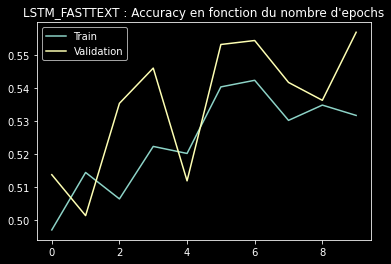

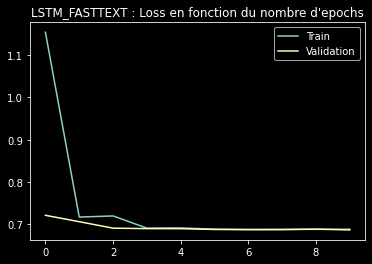

LSTM_FASTTEXT - max accuracy : 0.5567799806594849
LSTM_FASTTEXT - best time : 2.935499668121338 



Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 31, 10)            119550    
                                                                 
 lstm_8 (LSTM)               (None, 50)                12200     
                                                                 
 dense_29 (Dense)            (None, 1)                 51        
                                                                 
Total params: 131,801
Trainable params: 12,251
Non-trainable params: 119,550
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 4s 49ms/step - loss: 0.6931 - accuracy: 0.4965 - val_loss: 0.6914 - val_accuracy: 0.5300
Epoch 2/10
63/63 [==============================] - 3s 42ms/step - loss: 0.6887 - accuracy: 0.5381 - val_loss: 0.6911 - val_accuracy: 0.5073
Epoch 3/10
63/63 [==============================] - 3s 45ms/step - loss: 0.6874 - accuracy: 0.5480 - val_loss: 0.6851 - val_accuracy: 0.5566
Epoch 4/10
63/63 [==============================] - 3s 42ms/step - loss: 0.6847 - accuracy: 0.5570 - val_loss: 0.6861 - val_accuracy: 0.5600
Epoch 5/10
63/63 [==============================] - 3s 43ms/step - loss: 0.6871 - accuracy: 0.5451 - val_loss: 0.6841 - val_accuracy: 0.5637
Epoch 6/10
63/63 [==============================] - 3s 43ms/step - loss: 0.6840 - accuracy: 0.5571 - val_loss: 0.6849 - val_accuracy: 0.5578
Epoch 7/10
63/63 [==============================] - 3s 42ms/step - loss: 0.6851 - accuracy: 0.5540 - val_loss: 0.6832 - val_accuracy: 0.5631
Epoch 8/10
63

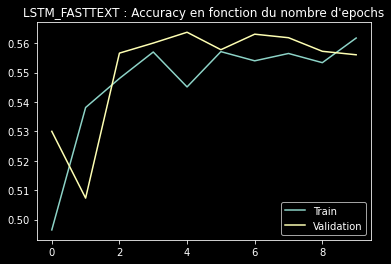

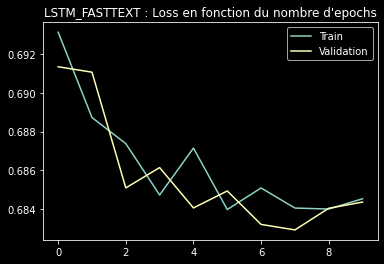

LSTM_FASTTEXT - max accuracy : 0.5637199878692627
LSTM_FASTTEXT - best time : 2.6529998779296875 



l'architecture B a un meilleur score d'accuracy (accuracy = 0.5637199878692627)


1563/1563 [==============================] - 4s 2ms/step


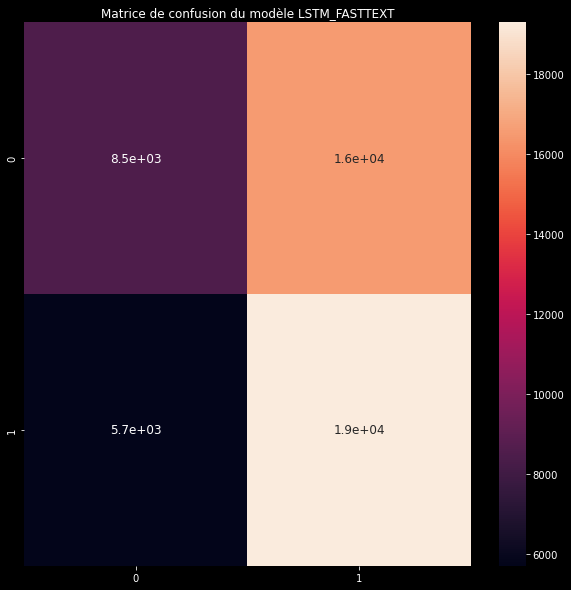

              precision    recall  f1-score   support

           0       0.60      0.34      0.43     25000
           1       0.54      0.77      0.63     25000

    accuracy                           0.56     50000
   macro avg       0.57      0.56      0.53     50000
weighted avg       0.57      0.56      0.53     50000



Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 gru_6 (GRU)                 (None, 50)                52800     
                                                                 
 dense_30 (Dense)            (None, 50)                2550      
                                                                 
 dense_31 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,641,901
Trainable params: 3,641,901
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 7s 95ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 6s 95ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 3/10
63/63 [==============================] - 6s 95ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 4/10
63/63 [==============================] - 6s 96ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/10
63/63 [==============================] - 6s 94ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 6/10
63/63 [==============================] - 6s 95ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 7/10
63/63 [==============================] - 6s 95ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 8/10
63

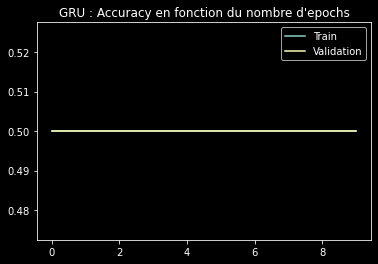

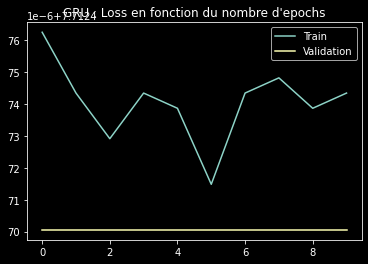

GRU - max accuracy : 0.5
GRU - best time : 7.100999116897583 



Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 gru_6 (GRU)                 (None, 50)                52800     
                                                                 
 dense_32 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,639,351
Trainable params: 3,639,351
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 7s 92ms/step - loss: 0.6942 - accuracy: 0.5005 - val_loss: 0.6933 - val_accuracy: 0.5031
Epoch 2/10
63/63 [==============================] - 6s 90ms/step - loss: 0.4399 - accuracy: 0.7669 - val_loss: 0.8079 - val_accuracy: 0.7115
Epoch 3/10
63/63 [==============================] - 6s 90ms/step - loss: 0.1315 - accuracy: 0.9567 - val_loss: 0.9431 - val_accuracy: 0.7045
Epoch 4/10
63/63 [==============================] - 6s 89ms/step - loss: 0.0815 - accuracy: 0.9761 - val_loss: 0.9530 - val_accuracy: 0.7073
Epoch 5/10
63/63 [==============================] - 6s 90ms/step - loss: 0.0603 - accuracy: 0.9856 - val_loss: 1.1817 - val_accuracy: 0.6994
Epoch 6/10
63/63 [==============================] - 6s 89ms/step - loss: 0.0655 - accuracy: 0.9834 - val_loss: 1.1853 - val_accuracy: 0.6971
Epoch 7/10
63/63 [==============================] - 6s 90ms/step - loss: 0.0555 - accuracy: 0.9871 - val_loss: 1.2628 - val_accuracy: 0.6944
Epoch 8/10
63

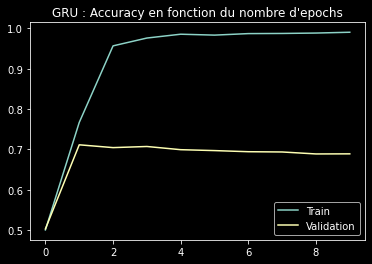

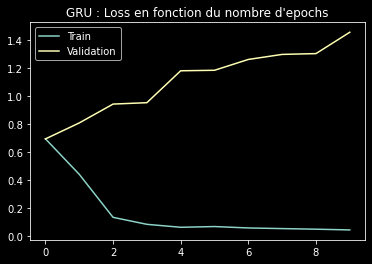

GRU - max accuracy : 0.7114800214767456
GRU - best time : 5.635999917984009 



l'architecture B a un meilleur score d'accuracy (accuracy = 0.7114800214767456)


1563/1563 [==============================] - 12s 8ms/step


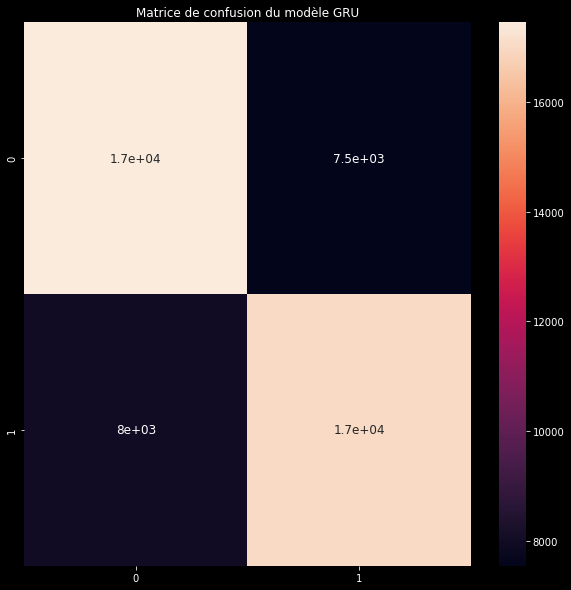

              precision    recall  f1-score   support

           0       0.69      0.70      0.69     25000
           1       0.69      0.68      0.69     25000

    accuracy                           0.69     50000
   macro avg       0.69      0.69      0.69     50000
weighted avg       0.69      0.69      0.69     50000



Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 gru_7 (GRU)                 (None, 50)                52800     
                                                                 
 dense_33 (Dense)            (None, 50)                2550      
                                                                 
 dense_34 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,641,901
Trainable params: 55,401
Non-trainable params: 3,586,500
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 5s 69ms/step - loss: 1.1793 - accuracy: 0.4961 - val_loss: 0.7633 - val_accuracy: 0.5007
Epoch 2/10
63/63 [==============================] - 4s 63ms/step - loss: 0.7048 - accuracy: 0.5460 - val_loss: 0.6834 - val_accuracy: 0.5611
Epoch 3/10
63/63 [==============================] - 4s 65ms/step - loss: 0.6803 - accuracy: 0.5809 - val_loss: 0.6814 - val_accuracy: 0.5423
Epoch 4/10
63/63 [==============================] - 4s 63ms/step - loss: 0.6510 - accuracy: 0.6295 - val_loss: 0.6474 - val_accuracy: 0.6720
Epoch 5/10
63/63 [==============================] - 4s 65ms/step - loss: 0.6349 - accuracy: 0.6948 - val_loss: 0.5899 - val_accuracy: 0.7085
Epoch 6/10
63/63 [==============================] - 4s 64ms/step - loss: 0.6418 - accuracy: 0.6231 - val_loss: 0.6534 - val_accuracy: 0.7080
Epoch 7/10
63/63 [==============================] - 4s 64ms/step - loss: 0.5748 - accuracy: 0.7116 - val_loss: 0.5758 - val_accuracy: 0.7199
Epoch 8/10
63

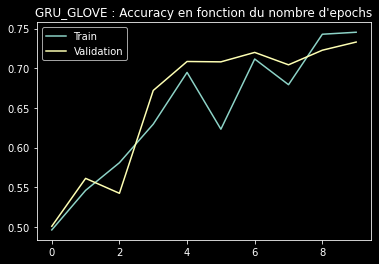

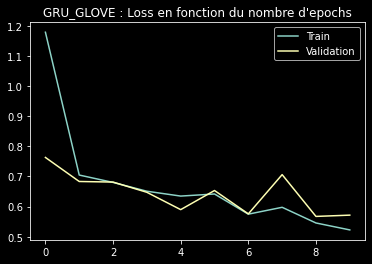

GRU_GLOVE - max accuracy : 0.7329999804496765
GRU_GLOVE - best time : 4.001500368118286 



Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 gru_7 (GRU)                 (None, 50)                52800     
                                                                 
 dense_35 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,639,351
Trainable params: 52,851
Non-trainable params: 3,586,500
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 5s 66ms/step - loss: 0.5531 - accuracy: 0.7300 - val_loss: 0.5448 - val_accuracy: 0.7282
Epoch 2/10
63/63 [==============================] - 4s 62ms/step - loss: 0.4830 - accuracy: 0.7701 - val_loss: 0.5330 - val_accuracy: 0.7394
Epoch 3/10
63/63 [==============================] - 4s 64ms/step - loss: 0.4551 - accuracy: 0.7897 - val_loss: 0.5365 - val_accuracy: 0.7368
Epoch 4/10
63/63 [==============================] - 4s 63ms/step - loss: 0.4330 - accuracy: 0.8014 - val_loss: 0.5277 - val_accuracy: 0.7409
Epoch 5/10
63/63 [==============================] - 4s 64ms/step - loss: 0.4074 - accuracy: 0.8192 - val_loss: 0.5245 - val_accuracy: 0.7460
Epoch 6/10
63/63 [==============================] - 4s 63ms/step - loss: 0.3897 - accuracy: 0.8282 - val_loss: 0.5348 - val_accuracy: 0.7379
Epoch 7/10
63/63 [==============================] - 4s 64ms/step - loss: 0.3574 - accuracy: 0.8486 - val_loss: 0.5589 - val_accuracy: 0.7455
Epoch 8/10
63

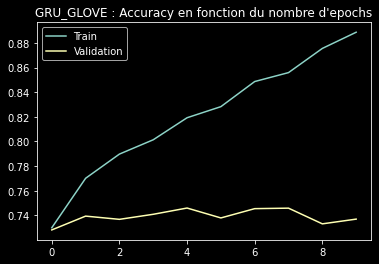

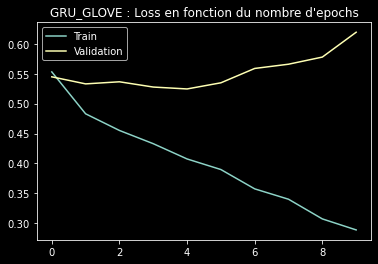

GRU_GLOVE - max accuracy : 0.7459800243377686
GRU_GLOVE - best time : 3.988499879837036 



l'architecture B a un meilleur score d'accuracy (accuracy = 0.7459800243377686)


1563/1563 [==============================] - 10s 6ms/step


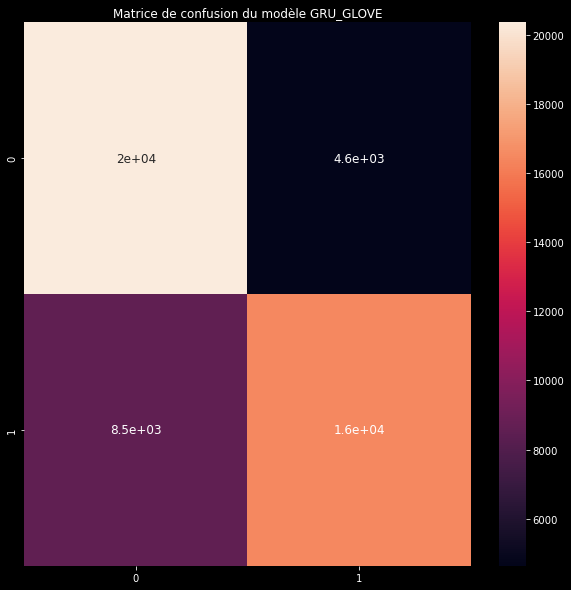

              precision    recall  f1-score   support

           0       0.71      0.81      0.76     25000
           1       0.78      0.66      0.71     25000

    accuracy                           0.74     50000
   macro avg       0.74      0.74      0.74     50000
weighted avg       0.74      0.74      0.74     50000



Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 31, 10)            119550    
                                                                 
 gru_8 (GRU)                 (None, 50)                9300      
                                                                 
 dense_36 (Dense)            (None, 50)                2550      
                                                                 
 dense_37 (Dense)            (None, 1)                 51        
                                                                 
Total params: 131,451
Trainable params: 11,901
Non-trainable params: 119,550
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 3s 38ms/step - loss: 1.1697 - accuracy: 0.5000 - val_loss: 0.7024 - val_accuracy: 0.4871
Epoch 2/10
63/63 [==============================] - 2s 35ms/step - loss: 0.6996 - accuracy: 0.4922 - val_loss: 0.6962 - val_accuracy: 0.4980
Epoch 3/10
63/63 [==============================] - 2s 34ms/step - loss: 0.6931 - accuracy: 0.4961 - val_loss: 0.6952 - val_accuracy: 0.5101
Epoch 4/10
63/63 [==============================] - 2s 33ms/step - loss: 0.6923 - accuracy: 0.5086 - val_loss: 0.6936 - val_accuracy: 0.4958
Epoch 5/10
63/63 [==============================] - 2s 34ms/step - loss: 0.6931 - accuracy: 0.5073 - val_loss: 0.6942 - val_accuracy: 0.4992
Epoch 6/10
63/63 [==============================] - 2s 34ms/step - loss: 0.6912 - accuracy: 0.5142 - val_loss: 0.6934 - val_accuracy: 0.4961
Epoch 7/10
63/63 [==============================] - 2s 33ms/step - loss: 0.6911 - accuracy: 0.5156 - val_loss: 0.6935 - val_accuracy: 0.4993
Epoch 8/10
63

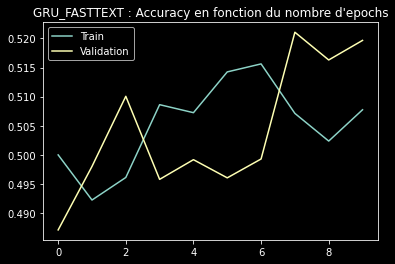

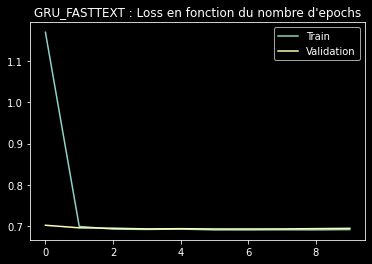

GRU_FASTTEXT - max accuracy : 0.5210599899291992
GRU_FASTTEXT - best time : 2.0744993686676025 



Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 31, 10)            119550    
                                                                 
 gru_8 (GRU)                 (None, 50)                9300      
                                                                 
 dense_38 (Dense)            (None, 1)                 51        
                                                                 
Total params: 128,901
Trainable params: 9,351
Non-trainable params: 119,550
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 3s 34ms/step - loss: 0.6936 - accuracy: 0.4963 - val_loss: 0.6931 - val_accuracy: 0.4997
Epoch 2/10
63/63 [==============================] - 2s 31ms/step - loss: 0.6931 - accuracy: 0.4904 - val_loss: 0.6930 - val_accuracy: 0.5064
Epoch 3/10
63/63 [==============================] - 2s 32ms/step - loss: 0.6922 - accuracy: 0.5132 - val_loss: 0.6916 - val_accuracy: 0.5314
Epoch 4/10
63/63 [==============================] - 2s 32ms/step - loss: 0.6895 - accuracy: 0.5421 - val_loss: 0.6889 - val_accuracy: 0.5427
Epoch 5/10
63/63 [==============================] - 2s 32ms/step - loss: 0.6899 - accuracy: 0.5231 - val_loss: 0.6886 - val_accuracy: 0.5430
Epoch 6/10
63/63 [==============================] - 2s 32ms/step - loss: 0.6879 - accuracy: 0.5396 - val_loss: 0.6864 - val_accuracy: 0.5482
Epoch 7/10
63/63 [==============================] - 2s 32ms/step - loss: 0.6862 - accuracy: 0.5447 - val_loss: 0.6852 - val_accuracy: 0.5538
Epoch 8/10
63

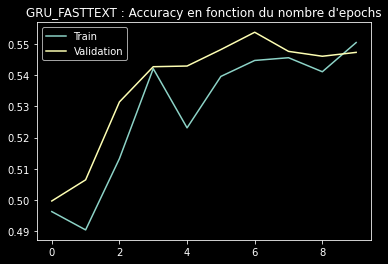

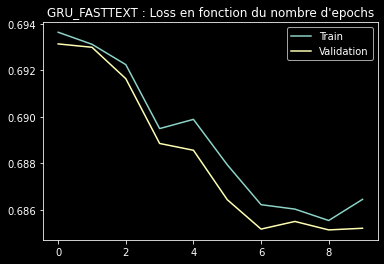

GRU_FASTTEXT - max accuracy : 0.5537999868392944
GRU_FASTTEXT - best time : 2.0005011558532715 



l'architecture B a un meilleur score d'accuracy (accuracy = 0.5537999868392944)


1563/1563 [==============================] - 3s 2ms/step


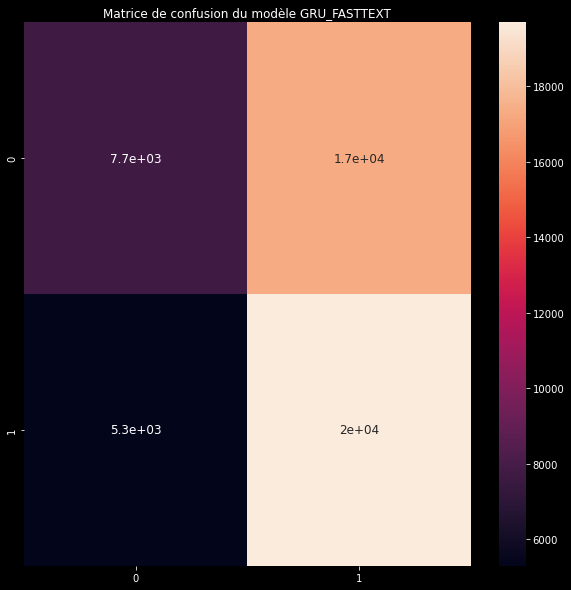

              precision    recall  f1-score   support

           0       0.59      0.31      0.40     25000
           1       0.53      0.79      0.64     25000

    accuracy                           0.55     50000
   macro avg       0.56      0.55      0.52     50000
weighted avg       0.56      0.55      0.52     50000



Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 bidirectional_6 (Bidirectio  (None, 100)              140400    
 nal)                                                            
                                                                 
 dense_39 (Dense)            (None, 50)                5050      
                                                                 
 dense_40 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,732,001
Trainable params: 3,732,001
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 13s 171ms/step - loss: 0.5060 - accuracy: 0.8008 - val_loss: 1.9418 - val_accuracy: 0.6998
Epoch 2/10
63/63 [==============================] - 11s 180ms/step - loss: 0.1234 - accuracy: 0.9732 - val_loss: 2.7027 - val_accuracy: 0.7020
Epoch 3/10
63/63 [==============================] - 11s 179ms/step - loss: 0.1038 - accuracy: 0.9790 - val_loss: 2.9292 - val_accuracy: 0.6962
Epoch 4/10
63/63 [==============================] - 11s 179ms/step - loss: 0.0981 - accuracy: 0.9849 - val_loss: 3.2346 - val_accuracy: 0.6957
Epoch 5/10
63/63 [==============================] - 11s 180ms/step - loss: 0.0899 - accuracy: 0.9858 - val_loss: 3.4208 - val_accuracy: 0.6903
Epoch 6/10
63/63 [==============================] - 11s 178ms/step - loss: 0.0806 - accuracy: 0.9905 - val_loss: 3.4897 - val_accuracy: 0.6949
Epoch 7/10
63/63 [==============================] - 11s 178ms/step - loss: 0.0781 - accuracy: 0.9916 - val_loss: 3.5996 - val_accuracy: 0.6938

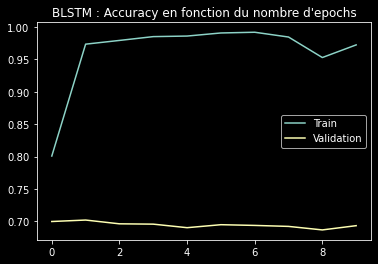

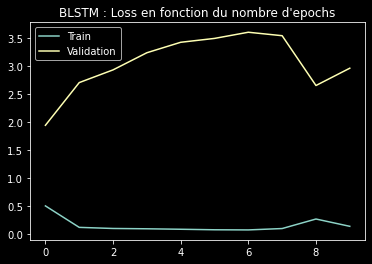

BLSTM - max accuracy : 0.7020400166511536
BLSTM - best time : 11.245999336242676 



Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 bidirectional_6 (Bidirectio  (None, 100)              140400    
 nal)                                                            
                                                                 
 dense_41 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,727,001
Trainable params: 3,727,001
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 13s 180ms/step - loss: 0.1914 - accuracy: 0.9644 - val_loss: 1.0467 - val_accuracy: 0.7051
Epoch 2/10
63/63 [==============================] - 11s 174ms/step - loss: 0.0605 - accuracy: 0.9847 - val_loss: 1.1738 - val_accuracy: 0.6985
Epoch 3/10
63/63 [==============================] - 11s 174ms/step - loss: 0.0525 - accuracy: 0.9851 - val_loss: 1.2353 - val_accuracy: 0.6963
Epoch 4/10
63/63 [==============================] - 11s 174ms/step - loss: 0.0447 - accuracy: 0.9885 - val_loss: 1.2680 - val_accuracy: 0.6915
Epoch 5/10
63/63 [==============================] - 11s 173ms/step - loss: 0.0353 - accuracy: 0.9916 - val_loss: 1.3329 - val_accuracy: 0.6943
Epoch 6/10
63/63 [==============================] - 11s 172ms/step - loss: 0.0339 - accuracy: 0.9912 - val_loss: 1.3538 - val_accuracy: 0.6932
Epoch 7/10
63/63 [==============================] - 11s 173ms/step - loss: 0.0280 - accuracy: 0.9935 - val_loss: 1.4776 - val_accuracy: 0.6906

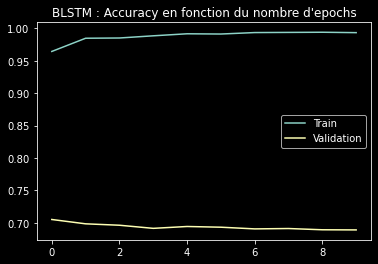

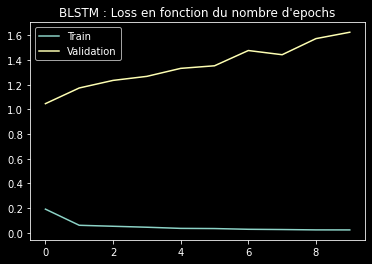

BLSTM - max accuracy : 0.7051399946212769
BLSTM - best time : 13.128000974655151 



l'architecture B a un meilleur score d'accuracy (accuracy = 0.7051399946212769)


1563/1563 [==============================] - 22s 14ms/step


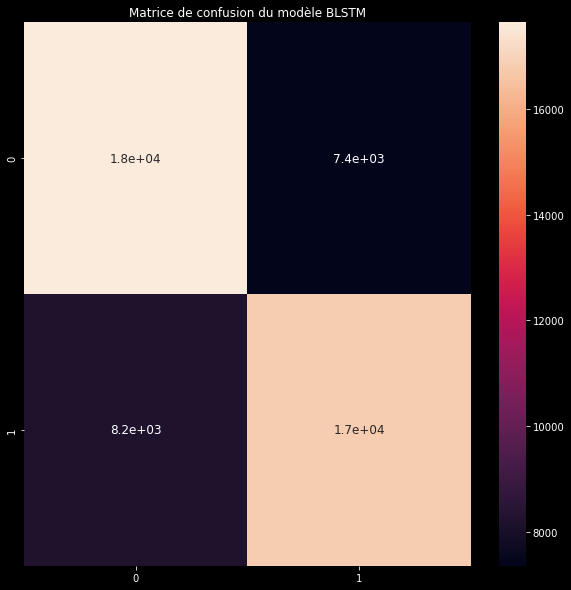

              precision    recall  f1-score   support

           0       0.68      0.71      0.69     25000
           1       0.70      0.67      0.68     25000

    accuracy                           0.69     50000
   macro avg       0.69      0.69      0.69     50000
weighted avg       0.69      0.69      0.69     50000



Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 bidirectional_7 (Bidirectio  (None, 100)              140400    
 nal)                                                            
                                                                 
 dense_42 (Dense)            (None, 50)                5050      
                                                                 
 dense_43 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,732,001
Trainable params: 145,501
Non-trainable params: 3,586,500
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 11s 149ms/step - loss: 1.0681 - accuracy: 0.5335 - val_loss: 0.6687 - val_accuracy: 0.5971
Epoch 2/10
63/63 [==============================] - 9s 145ms/step - loss: 0.6235 - accuracy: 0.6520 - val_loss: 0.6535 - val_accuracy: 0.6168
Epoch 3/10
63/63 [==============================] - 9s 144ms/step - loss: 0.6193 - accuracy: 0.6733 - val_loss: 0.6016 - val_accuracy: 0.6828
Epoch 4/10
63/63 [==============================] - 9s 145ms/step - loss: 0.5715 - accuracy: 0.7036 - val_loss: 0.5950 - val_accuracy: 0.7062
Epoch 5/10
63/63 [==============================] - 9s 145ms/step - loss: 0.5422 - accuracy: 0.7275 - val_loss: 0.7659 - val_accuracy: 0.5372
Epoch 6/10
63/63 [==============================] - 9s 145ms/step - loss: 0.5973 - accuracy: 0.6823 - val_loss: 0.6048 - val_accuracy: 0.7072
Epoch 7/10
63/63 [==============================] - 9s 145ms/step - loss: 0.5263 - accuracy: 0.7374 - val_loss: 0.5668 - val_accuracy: 0.7132
Epoch

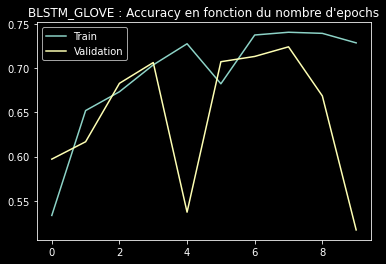

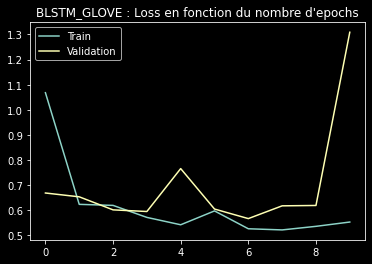

BLSTM_GLOVE - max accuracy : 0.7240200042724609
BLSTM_GLOVE - best time : 9.064499855041504 



Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 bidirectional_7 (Bidirectio  (None, 100)              140400    
 nal)                                                            
                                                                 
 dense_44 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,727,001
Trainable params: 140,501
Non-trainable params: 3,586,500
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 11s 145ms/step - loss: 0.5721 - accuracy: 0.7031 - val_loss: 0.5473 - val_accuracy: 0.7200
Epoch 2/10
63/63 [==============================] - 9s 137ms/step - loss: 0.4974 - accuracy: 0.7560 - val_loss: 0.5415 - val_accuracy: 0.7298
Epoch 3/10
63/63 [==============================] - 9s 137ms/step - loss: 0.4668 - accuracy: 0.7806 - val_loss: 0.5379 - val_accuracy: 0.7313
Epoch 4/10
63/63 [==============================] - 9s 137ms/step - loss: 0.4412 - accuracy: 0.7956 - val_loss: 0.5342 - val_accuracy: 0.7324
Epoch 5/10
63/63 [==============================] - 9s 137ms/step - loss: 0.4173 - accuracy: 0.8106 - val_loss: 0.5348 - val_accuracy: 0.7383
Epoch 6/10
63/63 [==============================] - 9s 137ms/step - loss: 0.3850 - accuracy: 0.8317 - val_loss: 0.5612 - val_accuracy: 0.7334
Epoch 7/10
63/63 [==============================] - 9s 138ms/step - loss: 0.3523 - accuracy: 0.8478 - val_loss: 0.5889 - val_accuracy: 0.7367
Epoch

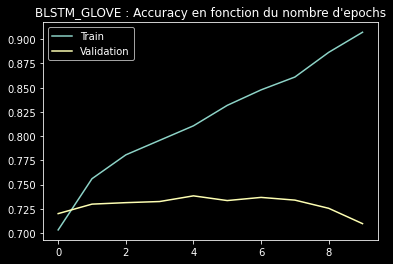

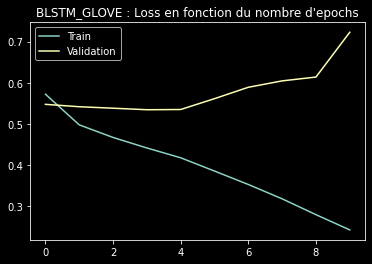

BLSTM_GLOVE - max accuracy : 0.7383000254631042
BLSTM_GLOVE - best time : 8.536999464035034 



l'architecture B a un meilleur score d'accuracy (accuracy = 0.7383000254631042)


1563/1563 [==============================] - 25s 16ms/step


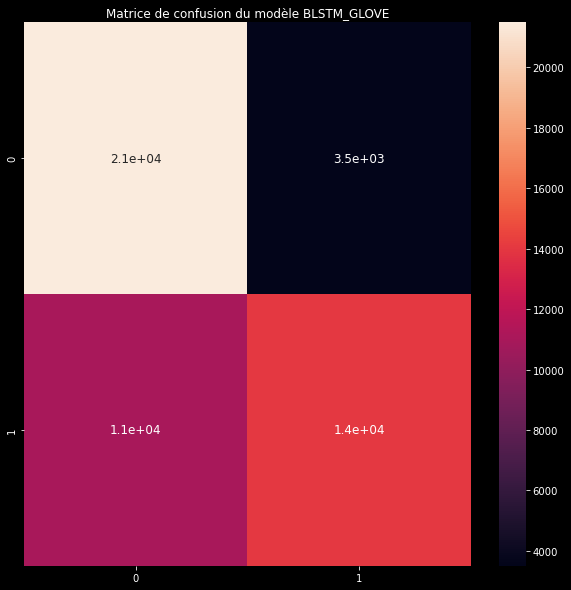

              precision    recall  f1-score   support

           0       0.66      0.86      0.75     25000
           1       0.80      0.56      0.66     25000

    accuracy                           0.71     50000
   macro avg       0.73      0.71      0.70     50000
weighted avg       0.73      0.71      0.70     50000



Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 31, 10)            119550    
                                                                 
 bidirectional_8 (Bidirectio  (None, 100)              24400     
 nal)                                                            
                                                                 
 dense_45 (Dense)            (None, 50)                5050      
                                                                 
 dense_46 (Dense)            (None, 1)                 51        
                                                                 
Total params: 149,051
Trainable params: 29,501
Non-trainable params: 119,550
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 6s 68ms/step - loss: 0.9086 - accuracy: 0.4944 - val_loss: 0.6984 - val_accuracy: 0.5002
Epoch 2/10
63/63 [==============================] - 4s 60ms/step - loss: 0.6947 - accuracy: 0.5049 - val_loss: 0.6952 - val_accuracy: 0.5020
Epoch 3/10
63/63 [==============================] - 4s 59ms/step - loss: 0.6907 - accuracy: 0.5219 - val_loss: 0.6892 - val_accuracy: 0.5367
Epoch 4/10
63/63 [==============================] - 4s 60ms/step - loss: 0.6881 - accuracy: 0.5418 - val_loss: 0.6884 - val_accuracy: 0.5390
Epoch 5/10
63/63 [==============================] - 4s 58ms/step - loss: 0.6887 - accuracy: 0.5371 - val_loss: 0.6877 - val_accuracy: 0.5514
Epoch 6/10
63/63 [==============================] - 4s 59ms/step - loss: 0.6863 - accuracy: 0.5447 - val_loss: 0.6864 - val_accuracy: 0.5535
Epoch 7/10
63/63 [==============================] - 4s 59ms/step - loss: 0.6853 - accuracy: 0.5436 - val_loss: 0.6863 - val_accuracy: 0.5558
Epoch 8/10
63

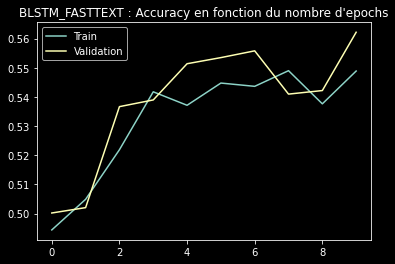

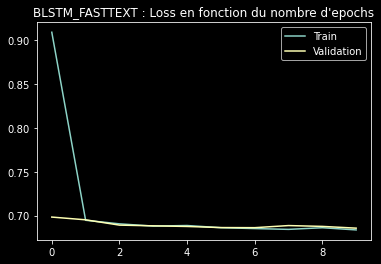

BLSTM_FASTTEXT - max accuracy : 0.5621799826622009
BLSTM_FASTTEXT - best time : 3.687000274658203 



Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 31, 10)            119550    
                                                                 
 bidirectional_8 (Bidirectio  (None, 100)              24400     
 nal)                                                            
                                                                 
 dense_47 (Dense)            (None, 1)                 101       
                                                                 
Total params: 144,051
Trainable params: 24,501
Non-trainable params: 119,550
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 6s 67ms/step - loss: 0.6906 - accuracy: 0.5264 - val_loss: 0.6889 - val_accuracy: 0.5360
Epoch 2/10
63/63 [==============================] - 4s 64ms/step - loss: 0.6875 - accuracy: 0.5399 - val_loss: 0.6883 - val_accuracy: 0.5189
Epoch 3/10
63/63 [==============================] - 4s 63ms/step - loss: 0.6865 - accuracy: 0.5509 - val_loss: 0.6872 - val_accuracy: 0.5582
Epoch 4/10
63/63 [==============================] - 4s 62ms/step - loss: 0.6843 - accuracy: 0.5546 - val_loss: 0.6853 - val_accuracy: 0.5567
Epoch 5/10
63/63 [==============================] - 4s 62ms/step - loss: 0.6850 - accuracy: 0.5506 - val_loss: 0.6855 - val_accuracy: 0.5571
Epoch 6/10
63/63 [==============================] - 4s 63ms/step - loss: 0.6828 - accuracy: 0.5605 - val_loss: 0.6854 - val_accuracy: 0.5571
Epoch 7/10
63/63 [==============================] - 4s 62ms/step - loss: 0.6826 - accuracy: 0.5660 - val_loss: 0.6840 - val_accuracy: 0.5583
Epoch 8/10
63

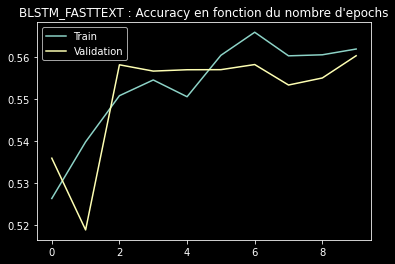

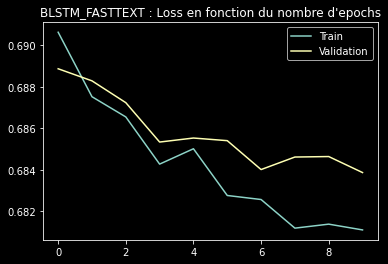

BLSTM_FASTTEXT - max accuracy : 0.5604000091552734
BLSTM_FASTTEXT - best time : 3.8844990730285645 



l'architecture A a un meilleur score d'accuracy (accuracy = 0.5621799826622009)


1563/1563 [==============================] - 5s 3ms/step


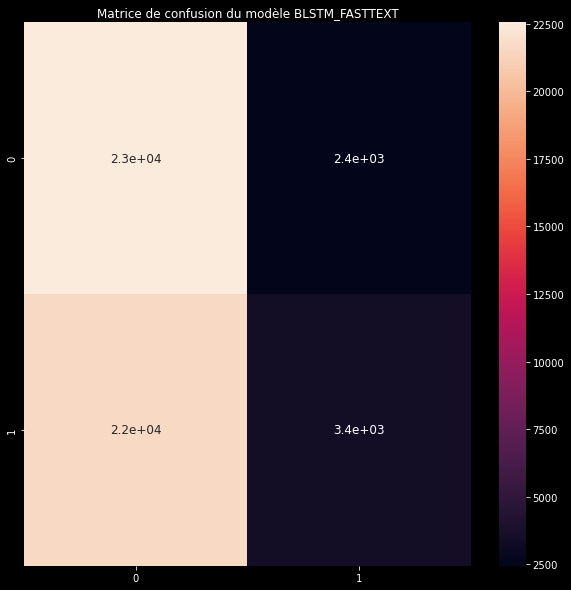

              precision    recall  f1-score   support

           0       0.51      0.90      0.65     25000
           1       0.58      0.14      0.22     25000

    accuracy                           0.52     50000
   macro avg       0.55      0.52      0.44     50000
weighted avg       0.55      0.52      0.44     50000



Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 bidirectional_9 (Bidirectio  (None, 100)              105600    
 nal)                                                            
                                                                 
 dense_48 (Dense)            (None, 50)                5050      
                                                                 
 dense_49 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,697,201
Trainable params: 3,697,201
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 11s 152ms/step - loss: 0.6291 - accuracy: 0.7590 - val_loss: 1.6907 - val_accuracy: 0.6990
Epoch 2/10
63/63 [==============================] - 9s 146ms/step - loss: 0.1108 - accuracy: 0.9778 - val_loss: 3.1179 - val_accuracy: 0.6944
Epoch 3/10
63/63 [==============================] - 9s 146ms/step - loss: 0.0814 - accuracy: 0.9864 - val_loss: 3.3537 - val_accuracy: 0.6916
Epoch 4/10
63/63 [==============================] - 9s 146ms/step - loss: 0.1464 - accuracy: 0.9800 - val_loss: 2.7712 - val_accuracy: 0.6867
Epoch 5/10
63/63 [==============================] - 9s 148ms/step - loss: 0.0714 - accuracy: 0.9859 - val_loss: 3.3729 - val_accuracy: 0.6903
Epoch 6/10
63/63 [==============================] - 9s 147ms/step - loss: 0.0502 - accuracy: 0.9921 - val_loss: 3.3916 - val_accuracy: 0.6862
Epoch 7/10
63/63 [==============================] - 9s 147ms/step - loss: 0.0494 - accuracy: 0.9929 - val_loss: 3.5383 - val_accuracy: 0.6890
Epoch

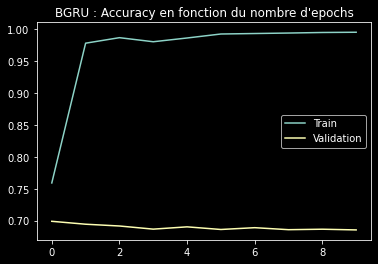

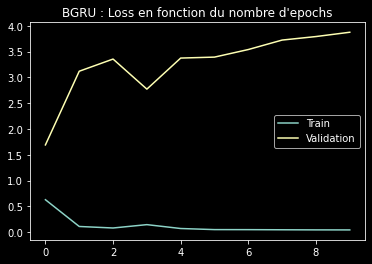

BGRU - max accuracy : 0.69896000623703
BGRU - best time : 11.436497449874878 



Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 bidirectional_9 (Bidirectio  (None, 100)              105600    
 nal)                                                            
                                                                 
 dense_50 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,692,201
Trainable params: 3,692,201
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 12s 157ms/step - loss: 0.1617 - accuracy: 0.9826 - val_loss: 0.9165 - val_accuracy: 0.6882
Epoch 2/10
63/63 [==============================] - 9s 151ms/step - loss: 0.0485 - accuracy: 0.9896 - val_loss: 1.1353 - val_accuracy: 0.6894
Epoch 3/10
63/63 [==============================] - 9s 149ms/step - loss: 0.0363 - accuracy: 0.9918 - val_loss: 1.2177 - val_accuracy: 0.6859
Epoch 4/10
63/63 [==============================] - 9s 151ms/step - loss: 0.0284 - accuracy: 0.9939 - val_loss: 1.3379 - val_accuracy: 0.6802
Epoch 5/10
63/63 [==============================] - 9s 150ms/step - loss: 0.0262 - accuracy: 0.9936 - val_loss: 1.4764 - val_accuracy: 0.6811
Epoch 6/10
63/63 [==============================] - 9s 151ms/step - loss: 0.0241 - accuracy: 0.9939 - val_loss: 1.5013 - val_accuracy: 0.6772
Epoch 7/10
63/63 [==============================] - 9s 149ms/step - loss: 0.0216 - accuracy: 0.9950 - val_loss: 1.5845 - val_accuracy: 0.6789
Epoch

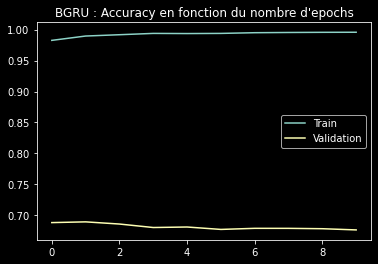

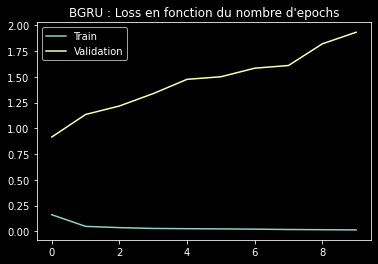

BGRU - max accuracy : 0.6893799901008606
BGRU - best time : 9.428499221801758 



l'architecture A a un meilleur score d'accuracy (accuracy = 0.69896000623703)


1563/1563 [==============================] - 20s 13ms/step


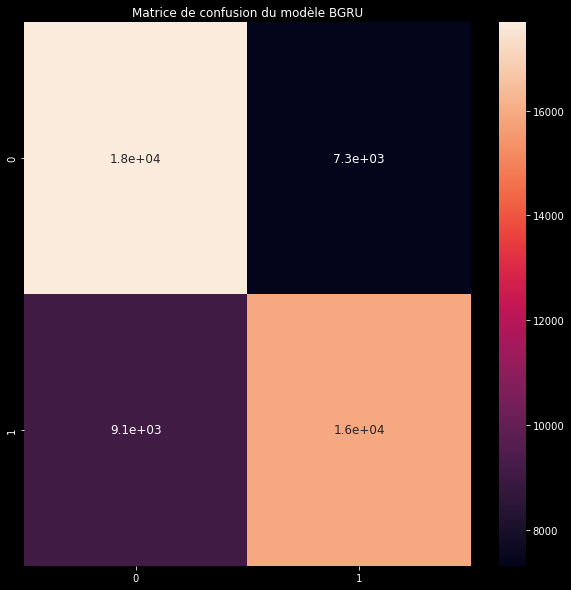

              precision    recall  f1-score   support

           0       0.66      0.71      0.68     25000
           1       0.69      0.64      0.66     25000

    accuracy                           0.67     50000
   macro avg       0.67      0.67      0.67     50000
weighted avg       0.67      0.67      0.67     50000



Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 bidirectional_10 (Bidirecti  (None, 100)              105600    
 onal)                                                           
                                                                 
 dense_51 (Dense)            (None, 50)                5050      
                                                                 
 dense_52 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,697,201
Trainable params: 110,701
Non-trainable params: 3,586,500
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 9s 119ms/step - loss: 0.7695 - accuracy: 0.5422 - val_loss: 0.6785 - val_accuracy: 0.5850
Epoch 2/10
63/63 [==============================] - 7s 116ms/step - loss: 0.6535 - accuracy: 0.6219 - val_loss: 0.6470 - val_accuracy: 0.6245
Epoch 3/10
63/63 [==============================] - 7s 116ms/step - loss: 0.6342 - accuracy: 0.6531 - val_loss: 0.6510 - val_accuracy: 0.6279
Epoch 4/10
63/63 [==============================] - 7s 115ms/step - loss: 0.6084 - accuracy: 0.6756 - val_loss: 0.6231 - val_accuracy: 0.6471
Epoch 5/10
63/63 [==============================] - 7s 115ms/step - loss: 0.5855 - accuracy: 0.6959 - val_loss: 0.6579 - val_accuracy: 0.6162
Epoch 6/10
63/63 [==============================] - 7s 116ms/step - loss: 0.5888 - accuracy: 0.6930 - val_loss: 0.6360 - val_accuracy: 0.6905
Epoch 7/10
63/63 [==============================] - 7s 114ms/step - loss: 0.5877 - accuracy: 0.7059 - val_loss: 0.6049 - val_accuracy: 0.7008
Epoch 

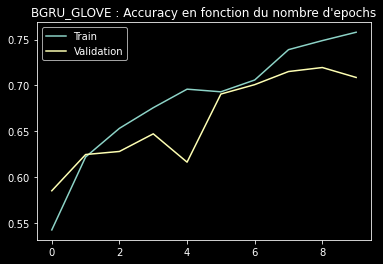

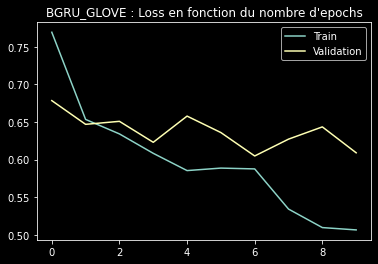

BGRU_GLOVE - max accuracy : 0.7195000052452087
BGRU_GLOVE - best time : 7.282500743865967 



Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 bidirectional_10 (Bidirecti  (None, 100)              105600    
 onal)                                                           
                                                                 
 dense_53 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,692,201
Trainable params: 105,701
Non-trainable params: 3,586,500
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 9s 118ms/step - loss: 0.5701 - accuracy: 0.6957 - val_loss: 0.5519 - val_accuracy: 0.7193
Epoch 2/10
63/63 [==============================] - 7s 109ms/step - loss: 0.4988 - accuracy: 0.7579 - val_loss: 0.5348 - val_accuracy: 0.7324
Epoch 3/10
63/63 [==============================] - 7s 110ms/step - loss: 0.4661 - accuracy: 0.7782 - val_loss: 0.5393 - val_accuracy: 0.7314
Epoch 4/10
63/63 [==============================] - 7s 111ms/step - loss: 0.4386 - accuracy: 0.7980 - val_loss: 0.5342 - val_accuracy: 0.7350
Epoch 5/10
63/63 [==============================] - 7s 110ms/step - loss: 0.4123 - accuracy: 0.8076 - val_loss: 0.5365 - val_accuracy: 0.7368
Epoch 6/10
63/63 [==============================] - 7s 111ms/step - loss: 0.3870 - accuracy: 0.8253 - val_loss: 0.5554 - val_accuracy: 0.7376
Epoch 7/10
63/63 [==============================] - 7s 111ms/step - loss: 0.3506 - accuracy: 0.8459 - val_loss: 0.5948 - val_accuracy: 0.7370
Epoch 

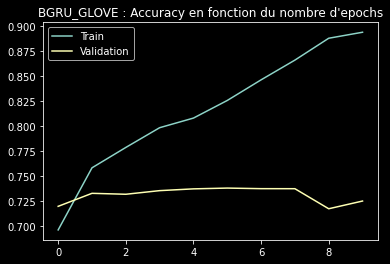

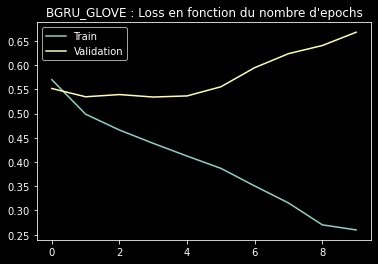

BGRU_GLOVE - max accuracy : 0.7376000285148621
BGRU_GLOVE - best time : 6.889499664306641 



l'architecture B a un meilleur score d'accuracy (accuracy = 0.7376000285148621)


1563/1563 [==============================] - 19s 12ms/step


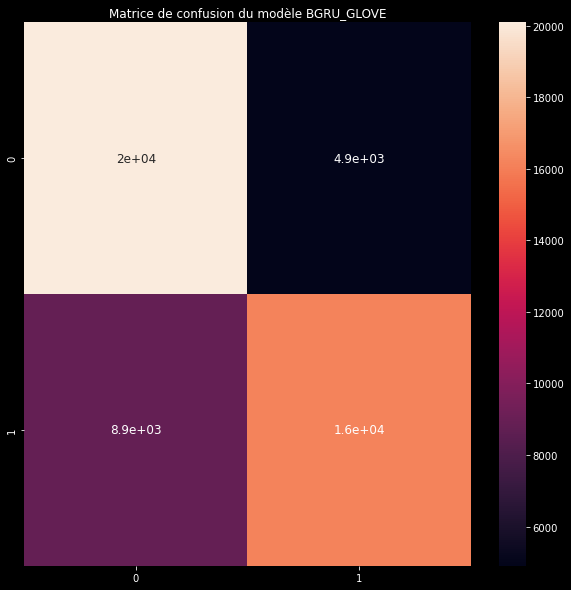

              precision    recall  f1-score   support

           0       0.69      0.80      0.74     25000
           1       0.77      0.65      0.70     25000

    accuracy                           0.72     50000
   macro avg       0.73      0.72      0.72     50000
weighted avg       0.73      0.72      0.72     50000



Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 bidirectional_11 (Bidirecti  (None, 100)              105600    
 onal)                                                           
                                                                 
 dense_54 (Dense)            (None, 50)                5050      
                                                                 
 dense_55 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,697,201
Trainable params: 3,697,201
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 12s 155ms/step - loss: 0.6766 - accuracy: 0.7193 - val_loss: 0.9929 - val_accuracy: 0.6751
Epoch 2/10
63/63 [==============================] - 9s 151ms/step - loss: 0.1894 - accuracy: 0.9451 - val_loss: 2.4810 - val_accuracy: 0.6941
Epoch 3/10
63/63 [==============================] - 9s 150ms/step - loss: 0.0638 - accuracy: 0.9865 - val_loss: 3.3462 - val_accuracy: 0.6852
Epoch 4/10
63/63 [==============================] - 9s 149ms/step - loss: 0.0548 - accuracy: 0.9884 - val_loss: 3.2699 - val_accuracy: 0.6888
Epoch 5/10
63/63 [==============================] - 9s 150ms/step - loss: 0.0628 - accuracy: 0.9874 - val_loss: 2.6082 - val_accuracy: 0.6510
Epoch 6/10
63/63 [==============================] - 9s 149ms/step - loss: 0.0537 - accuracy: 0.9886 - val_loss: 3.4314 - val_accuracy: 0.6789
Epoch 7/10
63/63 [==============================] - 9s 152ms/step - loss: 0.0582 - accuracy: 0.9861 - val_loss: 3.2693 - val_accuracy: 0.6691
Epoch

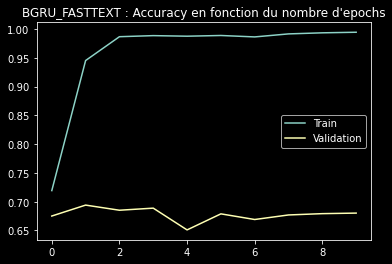

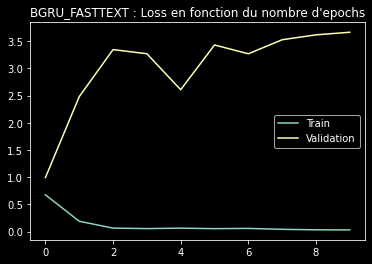

BGRU_FASTTEXT - max accuracy : 0.6940799951553345
BGRU_FASTTEXT - best time : 9.423499822616577 



Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 bidirectional_11 (Bidirecti  (None, 100)              105600    
 onal)                                                           
                                                                 
 dense_56 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,692,201
Trainable params: 3,692,201
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
63/63 [==============================] - 12s 157ms/step - loss: 0.2449 - accuracy: 0.9195 - val_loss: 0.9477 - val_accuracy: 0.6879
Epoch 2/10
63/63 [==============================] - 9s 150ms/step - loss: 0.0402 - accuracy: 0.9911 - val_loss: 1.1835 - val_accuracy: 0.6842
Epoch 3/10
63/63 [==============================] - 9s 151ms/step - loss: 0.0273 - accuracy: 0.9929 - val_loss: 1.2954 - val_accuracy: 0.6800
Epoch 4/10
63/63 [==============================] - 9s 150ms/step - loss: 0.0218 - accuracy: 0.9944 - val_loss: 1.4751 - val_accuracy: 0.6782
Epoch 5/10
63/63 [==============================] - 9s 149ms/step - loss: 0.0183 - accuracy: 0.9948 - val_loss: 1.6011 - val_accuracy: 0.6733
Epoch 6/10
63/63 [==============================] - 9s 148ms/step - loss: 0.0164 - accuracy: 0.9950 - val_loss: 1.7427 - val_accuracy: 0.6725
Epoch 7/10
63/63 [==============================] - 9s 149ms/step - loss: 0.0221 - accuracy: 0.9930 - val_loss: 1.7134 - val_accuracy: 0.6751
Epoch

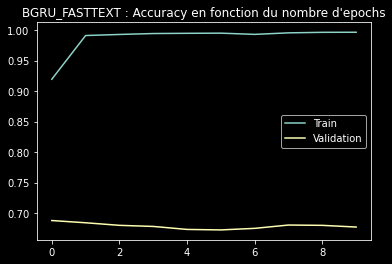

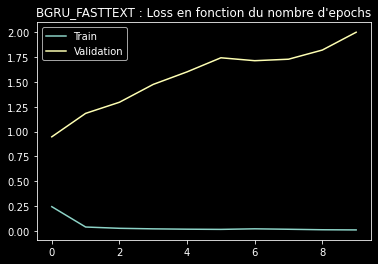

BGRU_FASTTEXT - max accuracy : 0.6879000067710876
BGRU_FASTTEXT - best time : 11.776996850967407 



l'architecture A a un meilleur score d'accuracy (accuracy = 0.6940799951553345)


1563/1563 [==============================] - 20s 12ms/step


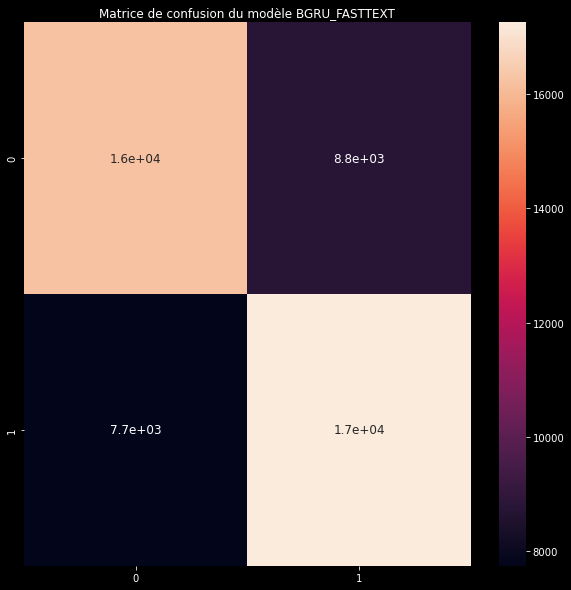

              precision    recall  f1-score   support

           0       0.68      0.65      0.66     25000
           1       0.66      0.69      0.68     25000

    accuracy                           0.67     50000
   macro avg       0.67      0.67      0.67     50000
weighted avg       0.67      0.67      0.67     50000



,accuracy
LSTM_GLOVE,0.74642
GRU_GLOVE,0.74598
LSTM,0.74044
BLSTM_GLOVE,0.73830
BGRU_GLOVE,0.73760
GRU,0.71148
RNN_GLOVE,0.70728
BLSTM,0.70514
BGRU,0.69896
BGRU_FASTTEXT,0.69408


,time
RNN_FASTTEXT,0.663501
GRU_FASTTEXT,2.000501
LSTM_FASTTEXT,2.653000
RNN_GLOVE,3.524999
BLSTM_FASTTEXT,3.687000
GRU_GLOVE,3.988500
LSTM,5.621500
GRU,5.636000
RNN,5.685500
LSTM_GLOVE,6.010999


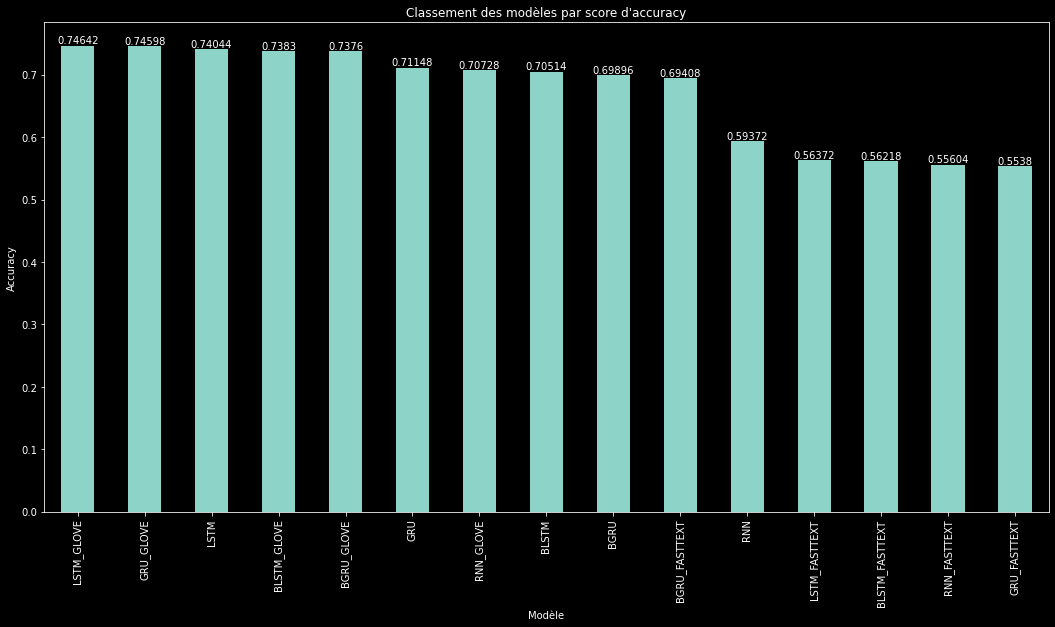

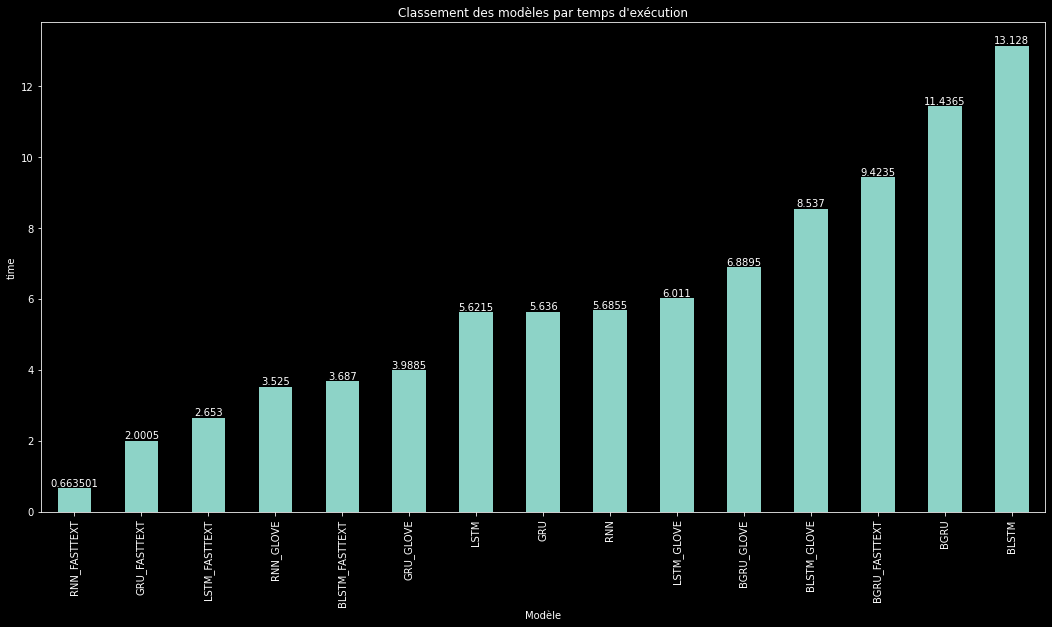

accuracy    0.74642
Name: LSTM_GLOVE, dtype: float64

In [118]:
models, history, times, max_accuracies, best_times, classification_report = build_and_run_all(
    cust_layers, 
    embeddings, 
    descriptions,
    X_seq_pad["train_smpl"],
    y["train_smpl"],
    X_seq_pad["val"],
    y["val"],
    batch_size,
    nb_epoch,
    time_callback
)

In [119]:
# save_to_file(sav_path, "models.sav", models)
for mdl in models:
    models[mdl].save(sav_path+"{}".format(mdl), save_format="h5")
# save_to_file(sav_path, "history.sav", history)
for h in history:
    with open(sav_path+"{}_hist.sav", "wb") as file_pi:
        pickle.dump(h, file_pi)
save_to_file(sav_path, "times.sav", times)
save_to_file(sav_path, "max_accuracies.sav", max_accuracies)
save_to_file(sav_path, "best_times.sav", best_times)
save_to_file(sav_path, "classification_report.sav", classification_report)

Nos deux meilleurs modèles, au coude-à-coude sont le modèle LSTM avec embedding Glove et le modèle GRU avec embedding GloVe, c'est donc ce modèle que nous allons optimiser.

On notera que nos modèle ont tendance à faire de l'overfitting, il pourrait donc être judicieux de rajouter des Dropout.

In [138]:
models["LSTM_GLOVE"].summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 lstm_7 (LSTM)               (None, 50)                70200     
                                                                 
 dense_26 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,656,751
Trainable params: 70,251
Non-trainable params: 3,586,500
_________________________________________________________________


In [120]:
models["GRU_GLOVE"].summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 gru_7 (GRU)                 (None, 50)                52800     
                                                                 
 dense_35 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,639,351
Trainable params: 52,851
Non-trainable params: 3,586,500
_________________________________________________________________


## Optimisation des deux meilleurs modèles

In [139]:
def build_GRU_GloVe(hp):
    GRU_GloVe = Sequential()
    GRU_GloVe.add(
        embeddings["glove"]
    )
    hp_dropout = hp.Float(
        "dropout1",
        min_value=0,
        max_value=0.5,
        step=0.1,
        default=0.5
    )
    GRU_GloVe.add(
        Dropout(
            rate=hp_dropout
        )
    )
    GRU_GloVe.add(
        GRU(
            units=hp.Int(
                'num_of_neurons',
                min_value=32,
                max_value=512,
                step=32
            )
        )
    )
    hp_dropout = hp.Float(
        "dropout2",
        min_value=0,
        max_value=0.5,
        step=0.1,
        default=0.5
    )
    GRU_GloVe.add(
        Dropout(
            rate=hp_dropout
        )
    )
    GRU_GloVe.add(
        Dense(
            units=1,
            activation="sigmoid"
        )
    )
    hp_learning_rate = hp.Choice(
        "learning_rate",
        values=[1e-1, 1e-2, 1e-3, 1e-4]
    )
    GRU_GloVe.compile(
        loss="binary_crossentropy",
        optimizer=Adam(hp_learning_rate),
        metrics=["accuracy"]
    )
    GRU_GloVe.summary()
    return GRU_GloVe

def build_LSTM_GloVe(hp):
    LSTM_GloVe = Sequential()
    LSTM_GloVe.add(
        embeddings["glove"]
    )
    hp_dropout = hp.Float(
        "dropout1",
        min_value=0,
        max_value=0.5,
        step=0.1,
        default=0.5
    )
    LSTM_GloVe.add(
        Dropout(
            rate=hp_dropout
        )
    )
    LSTM_GloVe.add(
        LSTM(
            units=hp.Int(
                'num_of_neurons',
                min_value=32,
                max_value=512,
                step=32
            )
        )
    )
    hp_dropout = hp.Float(
        "dropout2",
        min_value=0,
        max_value=0.5,
        step=0.1,
        default=0.5
    )
    LSTM_GloVe.add(
        Dropout(
            rate=hp_dropout
        )
    )
    LSTM_GloVe.add(
        Dense(
            units=1,
            activation="sigmoid"
        )
    )
    hp_learning_rate = hp.Choice(
        "learning_rate",
        values=[1e-1, 1e-2, 1e-3, 1e-4]
    )
    LSTM_GloVe.compile(
        loss="binary_crossentropy",
        optimizer=Adam(hp_learning_rate),
        metrics=["accuracy"]
    )
    LSTM_GloVe.summary()
    return LSTM_GloVe

## GRU GloVe

In [122]:
tuner = RandomSearch(
    build_GRU_GloVe,
    objective="val_accuracy",
    max_trials=20,
    seed=seed,
    directory="kerasTuner",
    overwrite=True
)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 dropout (Dropout)           (None, 31, 300)           0         
                                                                 
 gru_12 (GRU)                (None, 32)                32064     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_57 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,618,597
Trainable params: 32,097
Non-trainable params: 3,586,500
_________________________________________________________________


In [123]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
dropout1 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
num_of_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout2 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [124]:
tuner.search(
    X_seq_pad["train_smpl"],
    y["train_smpl"],
    epochs = 10,
    validation_data = (
        X_seq_pad["val"],
        y["val"]
    )
)

Trial 20 Complete [00h 08m 15s]
val_accuracy: 0.7552800178527832

Best val_accuracy So Far: 0.7552800178527832
Total elapsed time: 05h 01m 12s
INFO:tensorflow:Oracle triggered exit


In [125]:
save_to_file(sav_path, "tuner.sav", tuner.results_summary())

Results summary
Results in kerasTuner\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
dropout1: 0.30000000000000004
num_of_neurons: 96
dropout2: 0.2
learning_rate: 0.001
Score: 0.7552800178527832
Trial summary
Hyperparameters:
dropout1: 0.1
num_of_neurons: 96
dropout2: 0.5
learning_rate: 0.001
Score: 0.7512000203132629
Trial summary
Hyperparameters:
dropout1: 0.30000000000000004
num_of_neurons: 288
dropout2: 0.30000000000000004
learning_rate: 0.001
Score: 0.7505199909210205
Trial summary
Hyperparameters:
dropout1: 0.4
num_of_neurons: 416
dropout2: 0.1
learning_rate: 0.001
Score: 0.7494400143623352
Trial summary
Hyperparameters:
dropout1: 0.0
num_of_neurons: 256
dropout2: 0.1
learning_rate: 0.001
Score: 0.7470600008964539
Trial summary
Hyperparameters:
dropout1: 0.0
num_of_neurons: 320
dropout2: 0.1
learning_rate: 0.001
Score: 0.746720016002655
Trial summary
Hyperparameters:
dropout1: 0.1
num_of_neurons: 448
dropout2: 0.2
learning_rate: 0.001
Score: 0.745379984378

In [126]:
best_model = tuner.get_best_models()[0]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 dropout (Dropout)           (None, 31, 300)           0         
                                                                 
 gru (GRU)                   (None, 96)                114624    
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 3,701,221
Trainable params: 114,721
Non-trainable params: 3,586,500
_________________________________________________________________


In [127]:
best_hps_tuner = tuner.get_best_hyperparameters()[0]
print("Meilleure valeur pour droupout1 : {}".format(best_hps_tuner.get("dropout1")))
print("Meilleure valeur pour droupout2 : {}".format(best_hps_tuner.get("dropout2")))
print("Nombre optimal de neurones : {}".format(best_hps_tuner.get("num_of_neurons")))
print("Valeur optimale de learning rate : {}".format(best_hps_tuner.get("learning_rate")))

Meilleure valeur pour droupout1 : 0.30000000000000004
Meilleure valeur pour droupout2 : 0.2
Nombre optimal de neurones : 96
Valeur optimale de learning rate : 0.001


In [128]:
best_model_config = best_model.get_config()
save_to_file(sav_path, "best_model_config.sav", best_model_config)
best_model_config 

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 31),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'embedding_7_input'}},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding_7',
    'trainable': False,
    'batch_input_shape': (None, 31),
    'dtype': 'float32',
    'input_dim': 11955,
    'output_dim': 300,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 31}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.30000000000000004,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'GRU',
   'config': {'name': 'gru',
    'trainable': True,
    'dtype': 'float32',
    'return_sequences

In [129]:
best_model_hp = tuner.get_best_hyperparameters()[0]
save_to_file(sav_path, "best_model_hp.sav", best_model_hp.values)
best_model_hp.values

{'dropout1': 0.30000000000000004,
 'num_of_neurons': 96,
 'dropout2': 0.2,
 'learning_rate': 0.001}

Les meilleurs hyperparamètres sont :
- 30% pour la première couche de Dropout
- 20% pour la deuxième couche de Dropout
- 0.001 pour le Learning Rate
- 96 neurones

### Nombre d'epochs optimal

In [130]:
%%time
history["best_model_GRU_GloVe"] = best_model.fit(
    X_seq_pad["train_smpl"],
    y["train_smpl"],
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(
        X_seq_pad["val"],
        y["val"]
    )
)

Epoch 1/10
63/63 [==============================] - 29s 445ms/step - loss: 0.3889 - accuracy: 0.8227 - val_loss: 0.5238 - val_accuracy: 0.7556
Epoch 2/10
63/63 [==============================] - 27s 439ms/step - loss: 0.3705 - accuracy: 0.8350 - val_loss: 0.5479 - val_accuracy: 0.7483
Epoch 3/10
63/63 [==============================] - 27s 440ms/step - loss: 0.3527 - accuracy: 0.8446 - val_loss: 0.5535 - val_accuracy: 0.7502
Epoch 4/10
63/63 [==============================] - 27s 439ms/step - loss: 0.3395 - accuracy: 0.8528 - val_loss: 0.5637 - val_accuracy: 0.7536
Epoch 5/10
63/63 [==============================] - 27s 439ms/step - loss: 0.3245 - accuracy: 0.8576 - val_loss: 0.5638 - val_accuracy: 0.7526
Epoch 6/10
63/63 [==============================] - 27s 439ms/step - loss: 0.3017 - accuracy: 0.8708 - val_loss: 0.6121 - val_accuracy: 0.7473
Epoch 7/10
63/63 [==============================] - 27s 440ms/step - loss: 0.2904 - accuracy: 0.8756 - val_loss: 0.6086 - val_accuracy: 0.7450

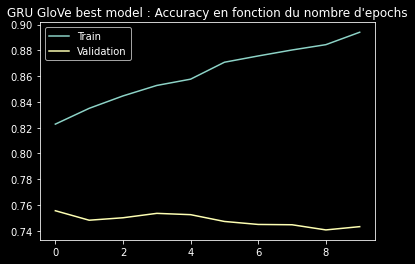

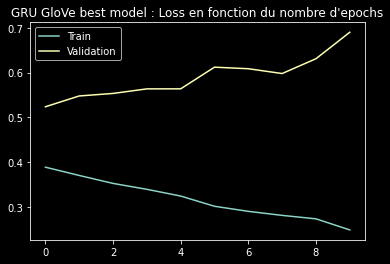

In [131]:
plot_metrics(history["best_model_GRU_GloVe"], "GRU GloVe best model")

In [132]:
accuracy_per_epoch = history["best_model_GRU_GloVe"].history["val_accuracy"]
best_epoch = accuracy_per_epoch.index(
    max(accuracy_per_epoch)
) + 1
best_epoch

1

## Entraînement du meilleur modèle avec le nombre d'epoch optimal

In [133]:
hypermodel = tuner.hypermodel.build(best_model_hp)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 dropout_2 (Dropout)         (None, 31, 300)           0         
                                                                 
 gru_1 (GRU)                 (None, 96)                114624    
                                                                 
 dropout_3 (Dropout)         (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 3,701,221
Trainable params: 114,721
Non-trainable params: 3,586,500
_________________________________________________________________


In [134]:
%%time
# réentrainement du modèle
history["hypermodel_GRU_GloVe"] = hypermodel.fit(
    X_seq_pad["train"],
    y["train"],
    batch_size=batch_size,
    validation_data=(
        X_seq_pad["val"],
        y["val"]
    )
)

9678/9678 [==============================] - 1250s 129ms/step - loss: 0.4636 - accuracy: 0.7784 - val_loss: 0.4260 - val_accuracy: 0.8046
CPU times: total: 37min 20s
Wall time: 20min 49s


In [135]:
hypermodel.save(sav_path+"hypermodel.h5")

Avec 1 epoch, nous obtenons une accuracy de 0.8046, ce qui est supérieur au modèle de référence (régression linéaire) qui a une accuracy de 0.74932

### Evaluation sur le jeu de comparaison

In [154]:
y_pred_hp_gru = hypermodel.predict(X_seq_pad["cmp"])

50/50 [==============================] - 2s 27ms/step


In [158]:
y_pred_hp_gru

array([[0.24948484],
       [0.36564648],
       [0.33686867],
       ...,
       [0.5266002 ],
       [0.5786171 ],
       [0.6300092 ]], dtype=float32)

In [160]:
y_pred_hp_gru_bin = np.where(y_pred_hp_gru>0.5, 1, 0)

In [159]:
y["cmp"]

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [164]:
accuracy_gru_hp = accuracy_score(y["cmp"], y_pred_hp_gru_bin)

In [165]:
print("Accuracy : ", accuracy_gru_hp)

Accuracy :  0.808125


Le score d'accuracy sur le modèle de comparaison est de 0.808, ce qui est bien supérieur à notre régression logistique.

### Matrice de confusion

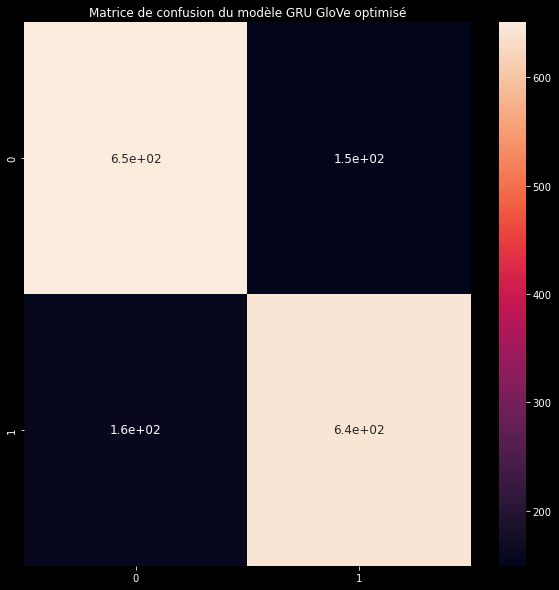

In [163]:
cm = confusion_matrix(y["cmp"], y_pred_hp_gru_bin)
cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, annot_kws={"size": 12})
plt.title("Matrice de confusion du modèle GRU GloVe optimisé")
plt.show()

## LSTM GloVe

In [140]:
tuner_lstm = RandomSearch(
    build_LSTM_GloVe,
    objective="val_accuracy",
    max_trials=20,
    seed=seed,
    directory="kerasTuner",
    overwrite=True
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 dropout_6 (Dropout)         (None, 31, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                42624     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,629,157
Trainable params: 42,657
Non-trainable params: 3,586,500
_________________________________________________________________


In [141]:
tuner_lstm.search_space_summary()

Search space summary
Default search space size: 4
dropout1 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
num_of_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout2 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [142]:
tuner_lstm.search(
    X_seq_pad["train_smpl"],
    y["train_smpl"],
    epochs = 10,
    validation_data = (
        X_seq_pad["val"],
        y["val"]
    )
)

Trial 20 Complete [00h 08m 14s]
val_accuracy: 0.7482200264930725

Best val_accuracy So Far: 0.7482200264930725
Total elapsed time: 06h 26m 23s
INFO:tensorflow:Oracle triggered exit


In [143]:
save_to_file(sav_path, "tuner_lstm.sav", tuner_lstm.results_summary())

Results summary
Results in kerasTuner\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
dropout1: 0.30000000000000004
num_of_neurons: 96
dropout2: 0.2
learning_rate: 0.001
Score: 0.7482200264930725
Trial summary
Hyperparameters:
dropout1: 0.1
num_of_neurons: 96
dropout2: 0.5
learning_rate: 0.001
Score: 0.7467600107192993
Trial summary
Hyperparameters:
dropout1: 0.30000000000000004
num_of_neurons: 288
dropout2: 0.30000000000000004
learning_rate: 0.001
Score: 0.7465999722480774
Trial summary
Hyperparameters:
dropout1: 0.4
num_of_neurons: 416
dropout2: 0.1
learning_rate: 0.001
Score: 0.7445399761199951
Trial summary
Hyperparameters:
dropout1: 0.0
num_of_neurons: 320
dropout2: 0.1
learning_rate: 0.001
Score: 0.743340015411377
Trial summary
Hyperparameters:
dropout1: 0.0
num_of_neurons: 256
dropout2: 0.1
learning_rate: 0.001
Score: 0.7428600192070007
Trial summary
Hyperparameters:
dropout1: 0.1
num_of_neurons: 448
dropout2: 0.2
learning_rate: 0.001
Score: 0.742139995098

In [144]:
best_model_lstm = tuner_lstm.get_best_models()[0]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 dropout (Dropout)           (None, 31, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 96)                152448    
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 3,739,045
Trainable params: 152,545
Non-trainable params: 3,586,500
_________________________________________________________________


In [145]:
best_hps_tuner_lstm = tuner_lstm.get_best_hyperparameters()[0]
print("Meilleure valeur pour droupout1 : {}".format(best_hps_tuner_lstm.get("dropout1")))
print("Meilleure valeur pour droupout2 : {}".format(best_hps_tuner_lstm.get("dropout2")))
print("Nombre optimal de neurones : {}".format(best_hps_tuner_lstm.get("num_of_neurons")))
print("Valeur optimale de learning rate : {}".format(best_hps_tuner_lstm.get("learning_rate")))

Meilleure valeur pour droupout1 : 0.30000000000000004
Meilleure valeur pour droupout2 : 0.2
Nombre optimal de neurones : 96
Valeur optimale de learning rate : 0.001


In [146]:
best_model_lstm_config = best_model_lstm.get_config()
save_to_file(sav_path, "best_model_lstm_config.sav", best_model_lstm_config)
best_model_lstm_config 

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 31),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'embedding_7_input'}},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding_7',
    'trainable': False,
    'batch_input_shape': (None, 31),
    'dtype': 'float32',
    'input_dim': 11955,
    'output_dim': 300,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 31}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.30000000000000004,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'LSTM',
   'config': {'name': 'lstm',
    'trainable': True,
    'dtype': 'float32',
    'return_sequenc

In [147]:
best_model_lstm_hp = tuner_lstm.get_best_hyperparameters()[0]
save_to_file(sav_path, "best_model_lstm_hp.sav", best_model_lstm_hp.values)
best_model_lstm_hp.values

{'dropout1': 0.30000000000000004,
 'num_of_neurons': 96,
 'dropout2': 0.2,
 'learning_rate': 0.001}

Les meilleurs hyperparamètres sont :
- 30% pour la première couche de Dropout
- 20% pour la deuxième couche de Dropout
- 0.001 pour le Learning Rate
- 96 neurones

### Nombre d'epochs optimal

In [148]:
%%time
history["best_model_LSTM_GloVe"] = best_model_lstm.fit(
    X_seq_pad["train_smpl"],
    y["train_smpl"],
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(
        X_seq_pad["val"],
        y["val"]
    )
)

Epoch 1/10
63/63 [==============================] - 37s 579ms/step - loss: 0.4191 - accuracy: 0.8055 - val_loss: 0.5367 - val_accuracy: 0.7445
Epoch 2/10
63/63 [==============================] - 36s 576ms/step - loss: 0.4078 - accuracy: 0.8139 - val_loss: 0.5436 - val_accuracy: 0.7452
Epoch 3/10
63/63 [==============================] - 36s 576ms/step - loss: 0.3871 - accuracy: 0.8267 - val_loss: 0.5555 - val_accuracy: 0.7444
Epoch 4/10
63/63 [==============================] - 36s 579ms/step - loss: 0.3754 - accuracy: 0.8351 - val_loss: 0.5439 - val_accuracy: 0.7457
Epoch 5/10
63/63 [==============================] - 36s 572ms/step - loss: 0.3553 - accuracy: 0.8454 - val_loss: 0.5744 - val_accuracy: 0.7451
Epoch 6/10
63/63 [==============================] - 36s 578ms/step - loss: 0.3387 - accuracy: 0.8516 - val_loss: 0.6163 - val_accuracy: 0.7465
Epoch 7/10
63/63 [==============================] - 36s 574ms/step - loss: 0.3418 - accuracy: 0.8529 - val_loss: 0.5886 - val_accuracy: 0.7402

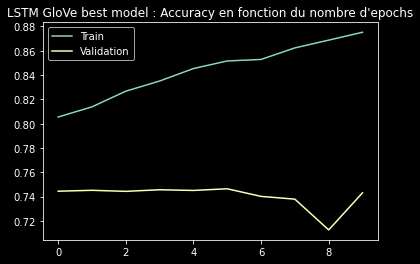

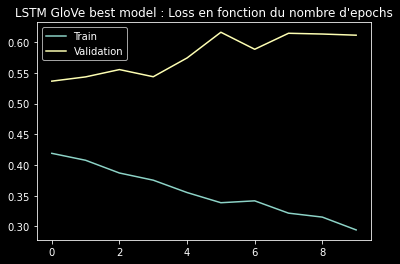

In [149]:
plot_metrics(history["best_model_LSTM_GloVe"], "LSTM GloVe best model")

In [150]:
accuracy_per_epoch_lstm = history["best_model_LSTM_GloVe"].history["val_accuracy"]
best_epoch_lstm = accuracy_per_epoch_lstm.index(
    max(accuracy_per_epoch_lstm)
) + 1
best_epoch_lstm

6

## Entraînement du meilleur modèle avec le nombre d'epoch optimal

In [151]:
hypermodel_lstm = tuner_lstm.hypermodel.build(best_model_lstm_hp)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 300)           3586500   
                                                                 
 dropout_2 (Dropout)         (None, 31, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 96)                152448    
                                                                 
 dropout_3 (Dropout)         (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 3,739,045
Trainable params: 152,545
Non-trainable params: 3,586,500
_________________________________________________________________


In [152]:
%%time
# réentrainement du modèle
history["hypermodel_LSTM_GloVe"] = hypermodel_lstm.fit(
    X_seq_pad["train"],
    y["train"],
    batch_size=batch_size,
    validation_data=(
        X_seq_pad["val"],
        y["val"]
    )
)

9678/9678 [==============================] - 1744s 180ms/step - loss: 0.4676 - accuracy: 0.7774 - val_loss: 0.4317 - val_accuracy: 0.8037
CPU times: total: 47min 18s
Wall time: 29min 4s


In [153]:
hypermodel_lstm.save(sav_path+"hypermodel_lstm.h5")

### Evaluation sur le jeu de comparaison

In [166]:
y_pred_hp_lstm = hypermodel_lstm.predict(X_seq_pad["cmp"])

50/50 [==============================] - 1s 23ms/step


In [167]:
y_pred_hp_lstm

array([[0.20048453],
       [0.33627683],
       [0.36714897],
       ...,
       [0.6376615 ],
       [0.5623317 ],
       [0.63452744]], dtype=float32)

In [168]:
y_pred_hp_lstm_bin = np.where(y_pred_hp_lstm>0.5, 1, 0)

In [169]:
y["cmp"]

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [172]:
accuracy_gru_lstm = accuracy_score(y["cmp"], y_pred_hp_lstm_bin)

In [173]:
print("Accuracy : ", accuracy_gru_lstm)

Accuracy :  0.803125


Le modèle LSTM optimisé, avec embedding GloVe, a un score d'accuracy de 0.803 sur le jeu de données de comparaison, ce qui est supérieur à notre baseline, mais légèrement en dessous du modèle GRU GloVe optimisé... Comme quoi il était judicieux d'optimiser ces deux modèles

### Matrice de confusion

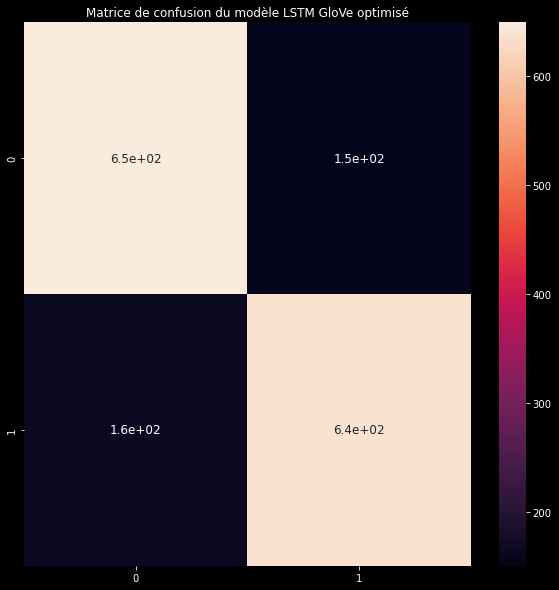

In [174]:
cm = confusion_matrix(y["cmp"], y_pred_hp_lstm_bin)
cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, annot_kws={"size": 12})
plt.title("Matrice de confusion du modèle LSTM GloVe optimisé")
plt.show()

## Conclusion

In [ ]:
Une fois optimisé, notre meilleur modèle est GRU, avec un embedding GloVe